In [1]:
from __future__ import print_function, division
import requests
from bs4 import BeautifulSoup
import re
import dateutil.parser
import pandas as pd
from decimal import *
from datetime import datetime, timedelta
from pandas import ExcelWriter
from dateutil import parser
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV
import numpy as np
from sklearn.metrics import r2_score
from sklearn.externals.six import StringIO


%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

/Users/pradnyanimkar/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
total_movies = pd.read_csv('total_movies')
total_movies.drop(['Unnamed: 0', 'index'], axis = 1,errors='ignore', inplace = True)

In [3]:
total_movies
total_movies['Release month'] = pd.DatetimeIndex(total_movies['Release Date']).month
total_movies['Release year'] = pd.DatetimeIndex(total_movies['Release Date']).year

In [4]:
# Drop duplicates
total_movies.drop_duplicates(subset='title', keep='first', inplace=True) #Note : There were no duplicates

In [5]:
# Focus on main stream movies : Filter on movies that run atleast 75 minutes : 1 hour 15 minutes
total_movies_model = total_movies[total_movies['Runtime'] > 75 ].reset_index() # droped about 179 movies
total_movies_model = total_movies[total_movies['MPAA Rating'] != "NC-17" ] # Dropping movies with Unknown rating (10) and NC-17 (2)
total_movies_model = total_movies[total_movies['MPAA Rating'] != "Unknown" ]
total_movies_model.dropna(axis=0, how='all') # Dropping rows which has all the NaNs

,Actor,Close_Date,Composer,Director,Distributor,Genre,In_Release,MPAA Rating,Opening_Weekend,Other_Text,...,Runtime,Theaters,Unnamed: 0.1,Writer,domestic_sales,foreign_sales,title,worldwide_sales,Release month,Release year
0,NaN,NaN,NaN,Andres Muschietti,Warner Bros. (New Line),Horror,NaN,R,123403419.000,"(#1 rank, 4,103 theaters, $30,076 average)",...,135.000,4148.000,nan,Cary Fukunaga,291182790.000,264800000.000,It,555982790.000,9.000,2017.000
1,John Boyega,2016-06-02 00:00:00,John Williams,J.J. Abrams,Buena Vista,Sci-Fi Fantasy,168 days / 24 weeks,PG-13,247966675.000,"(#1 rank, 4,134 theaters, $59,982 average)",...,136.000,4134.000,nan,J.J. Abrams,936662225.000,1131561399.000,Star Wars: The Force Awakens,2068223624.000,12.000,2015.000
2,Omar Sy,2015-11-19 00:00:00,Michael Giacchino,Colin Trevorrow,Universal,Action / Adventure,NaN,PG-13,208806270.000,"(#1 rank, 4,274 theaters, $48,855 average)",...,124.000,4291.000,nan,Derek Connolly,652270625.000,1019442583.000,Jurassic World,1671713208.000,6.000,2015.000
3,"Robert Downey, Jr.",2015-10-08 00:00:00,Danny Elfman,Joss Whedon,Buena Vista,Action / Adventure,161 days / 23 weeks,PG-13,191271109.000,"(#1 rank, 4,276 theaters, $44,731 average)",...,141.000,4276.000,nan,Joss Whedon,459005868.000,946397826.000,Avengers: Age of Ultron,1405403694.000,5.000,2015.000
4,Mindy Kaling,2015-12-10 00:00:00,Michael Giacchino,Pete Docter,Buena Vista,Animation,175 days / 25 weeks,PG,90440272.000,"(#2 rank, 3,946 theaters, $22,919 average)",...,94.000,4158.000,nan,Josh Cooley,356461711.000,501149463.000,Inside Out,857611174.000,6.000,2015.000
5,Tony Jaa,2015-07-24 00:00:00,Brian Tyler,James Wan,Universal,Action,NaN,PG-13,147187040.000,"(#1 rank, 4,004 theaters, $36,760 average)",...,137.000,4022.000,nan,Chris Morgan,353007020.000,1163038891.000,Furious 7,1516045911.000,4.000,2015.000
6,Sandra Bullock,2015-12-17 00:00:00,Heitor Pereira,Pierre Coffin,Universal,Animation,161 days / 23 weeks,PG,115718405.000,"(#1 rank, 4,301 theaters, $26,905 average)",...,91.000,4311.000,nan,Brian Lynch,336045770.000,823352627.000,Minions,1159398397.000,7.000,2015.000
7,Jennifer Lawrence,2016-02-25 00:00:00,NaN,Francis Lawrence,Lionsgate,Action / Adventure,98 days / 14 weeks,PG-13,102665981.000,"(#1 rank, 4,175 theaters, $24,591 average)",...,137.000,4175.000,nan,Peter Craig,281723902.000,371704359.000,The Hunger Games: Mockingjay - Part 2,653428261.000,11.000,2015.000
8,Sean Bean,2016-03-17 00:00:00,Dariusz Wolski,Ridley Scott,Fox,Sci-Fi,168 days / 24 weeks,PG-13,54308575.000,"(#1 rank, 3,831 theaters, $14,176 average)",...,141.000,3854.000,nan,Drew Goddard,228433663.000,401728227.000,The Martian,630161890.000,10.000,2015.000
9,Cate Blanchett,2015-09-17 00:00:00,NaN,Kenneth Branagh,Buena Vista,Fantasy,189 days / 27 weeks,PG,67877361.000,"(#1 rank, 3,845 theaters, $17,653 average)",...,112.000,3848.000,nan,Chris Weitz,201151353.000,342363000.000,Cinderella,543514353.000,3.000,2015.000


In [16]:
# Adjusting the total sales to today's rate
total_movies_model['Release Date2'] = total_movies_model['Release Date'].dropna().map(lambda x : str(x).split()[0]).map(lambda x : datetime.strptime(x,'%Y-%m-%d'))
total_movies_model['month_delta'] = total_movies_model["Release Date2"].map(lambda x : pd.to_datetime('today')- x )
days = total_movies_model.month_delta.map(lambda x: x.days) # gives difference in days between release date and current date
total_movies_model['adj_domestic_sales'] = total_movies_model['domestic_sales']* (1+0.01)** (days/365) # conveting sales to today's dollar amount
total_movies_model['adj_budget'] = total_movies_model['Production Budget']* (1+0.01)** (days/365) # conveting sales to today's dollar amount

In [333]:
total_movies_model

,Actor,Close_Date,Composer,Director,Distributor,Genre,In_Release,MPAA Rating,Opening_Weekend,Other_Text,...,domestic_sales,foreign_sales,title,worldwide_sales,Release month,Release year,Release Date2,month_delta,adj_domestic_sales,adj_budget
0,NaN,NaN,NaN,Andres Muschietti,Warner Bros. (New Line),Horror,NaN,R,123403419.000,"(#1 rank, 4,103 theaters, $30,076 average)",...,291182790.000,264800000.000,It,555982790.000,9.000,2017.000,2017-09-08,25 days,291381307.304,35023861.663
1,John Boyega,2016-06-02 00:00:00,John Williams,J.J. Abrams,Buena Vista,Sci-Fi Fantasy,168 days / 24 weeks,PG-13,247966675.000,"(#1 rank, 4,134 theaters, $59,982 average)",...,936662225.000,1131561399.000,Star Wars: The Force Awakens,2068223624.000,12.000,2015.000,2015-12-18,655 days,953537549.369,249414029.263
2,Omar Sy,2015-11-19 00:00:00,Michael Giacchino,Colin Trevorrow,Universal,Action / Adventure,NaN,PG-13,208806270.000,"(#1 rank, 4,274 theaters, $48,855 average)",...,652270625.000,1019442583.000,Jurassic World,1671713208.000,6.000,2015.000,2015-06-12,844 days,667452336.079,153491275.821
3,"Robert Downey, Jr.",2015-10-08 00:00:00,Danny Elfman,Joss Whedon,Buena Vista,Action / Adventure,161 days / 23 weeks,PG-13,191271109.000,"(#1 rank, 4,276 theaters, $44,731 average)",...,459005868.000,946397826.000,Avengers: Age of Ultron,1405403694.000,5.000,2015.000,2015-05-01,886 days,470227396.549,256111865.518
4,Mindy Kaling,2015-12-10 00:00:00,Michael Giacchino,Pete Docter,Buena Vista,Animation,175 days / 25 weeks,PG,90440272.000,"(#2 rank, 3,946 theaters, $22,919 average)",...,356461711.000,501149463.000,Inside Out,857611174.000,6.000,2015.000,2015-06-19,837 days,364688819.111,179038986.166
5,Tony Jaa,2015-07-24 00:00:00,Brian Tyler,James Wan,Universal,Action,NaN,PG-13,147187040.000,"(#1 rank, 4,004 theaters, $36,760 average)",...,353007020.000,1163038891.000,Furious 7,1516045911.000,4.000,2015.000,2015-04-03,914 days,361913293.466,194793649.595
6,Sandra Bullock,2015-12-17 00:00:00,Heitor Pereira,Pierre Coffin,Universal,Animation,161 days / 23 weeks,PG,115718405.000,"(#1 rank, 4,301 theaters, $26,905 average)",...,336045770.000,823352627.000,Minions,1159398397.000,7.000,2015.000,2015-07-10,816 days,343604914.902,75664584.925
7,Jennifer Lawrence,2016-02-25 00:00:00,NaN,Francis Lawrence,Lionsgate,Action / Adventure,98 days / 14 weeks,PG-13,102665981.000,"(#1 rank, 4,175 theaters, $24,591 average)",...,281723902.000,371704359.000,The Hunger Games: Mockingjay - Part 2,653428261.000,11.000,2015.000,2015-11-20,683 days,287018566.883,163007009.257
8,Sean Bean,2016-03-17 00:00:00,Dariusz Wolski,Ridley Scott,Fox,Sci-Fi,168 days / 24 weeks,PG-13,54308575.000,"(#1 rank, 3,831 theaters, $14,176 average)",...,228433663.000,401728227.000,The Martian,630161890.000,10.000,2015.000,2015-10-02,732 days,233037885.056,110176806.936
9,Cate Blanchett,2015-09-17 00:00:00,NaN,Kenneth Branagh,Buena Vista,Fantasy,189 days / 27 weeks,PG,67877361.000,"(#1 rank, 3,845 theaters, $17,653 average)",...,201151353.000,342363000.000,Cinderella,543514353.000,3.000,2015.000,2015-03-13,935 days,206344443.521,97452598.962


In [6]:
# Creating a "Genre_cln" which groups lot of genres in "Other" categories
#z = total_movies_model['Genre'].value_counts()
#writer = pd.ExcelWriter('Genre_list.xlsx') #Don't run this again. It will delete the Genre_cln column that I have added
#z.to_excel(writer,'Sheet1')
#writer.save()

Genre = pd.read_excel('Genre_list2.xlsx')
total_movies_model = total_movies_model.merge(Genre, on='Genre', how='left')

In [10]:
total_movies_model.columns

Index(['Actor', 'Close_Date', 'Composer', 'Director', 'Distributor', 'Genre',
       'In_Release', 'MPAA Rating', 'Opening_Weekend', 'Other_Text',
       'Producer', 'Production Budget', 'Release Date', 'Runtime', 'Theaters',
       'Unnamed: 0.1', 'Writer', 'domestic_sales', 'foreign_sales', 'title',
       'worldwide_sales', 'Release month', 'Release year', 'Release Date2',
       'month_delta', 'adj_domestic_sales', 'adj_budget', 'Genre_Cln'],
      dtype='object')

In [11]:
total_movies_model.shape

(2527, 28)

In [7]:
total_movies_model['MPAA Rating'].value_counts()

Unrated          1236
R                 677
PG-13             400
PG                162
Not Yet Rated      32
G                  16
NC-17               2
Name: MPAA Rating, dtype: int64

In [13]:
total_movies_model['Actor'].value_counts()

Carter Burwell             4
Will Smith                 4
Jason Blum                 4
Tom Hardy                  4
Johnny Depp                4
Michael Fassbender         4
Jesse Eisenberg            3
Emma Stone                 3
Marion Cotillard           3
Tom Hiddleston             3
Mark Wahlberg              3
James Franco               3
Jesse Plemons              3
Tom Holland                3
Michael Giacchino          3
Kevin Hart                 3
Matthew McConaughey        3
Jennifer Lawrence          3
Jennifer Aniston           2
Michael Keaton             2
Keira Knightley            2
Ben Affleck                2
Mandy Walker               2
Tobey Maguire              2
Ryan Kavanaugh             2
Mark Rylance               2
Megan Ellison              2
Reese Witherspoon          2
Steve Carell               2
Common                     2
                          ..
Olivia Wilde               1
Alicia Vikander            1
Felicity Jones             1
Robert Downey,

In [11]:
# Creating a "Male Vs Female" 
#x = total_movies_model['Actor'].value_counts()
#writer1 = pd.ExcelWriter('Actor_list.xlsx') #Don't run this again. It will delete the Genre_cln column that I have added
#x.to_excel(writer1,'Sheet1')
#writer1.save()

Actor = pd.read_excel('Actor_list2.xlsx')
total_movies_model = total_movies_model.merge(Actor, on='Actor', how='left')

In [23]:
# Calculating the day of the week
total_movies_model["Release_Day"] = total_movies_model['Release Date2'].dt.strftime("%A")

In [16]:
# Trying to see which are top 10 distributors
mean_adj_budget = total_movies_model.groupby(['Distributor']) ['adj_budget'].mean().reset_index()
mean_adj_budget.sort_values('adj_budget', ascending= False, inplace=True)
mean_adj_budget

,Distributor,adj_budget
45,Buena Vista,155643562.236
279,Warner Bros.,92712501.651
153,Lionsgate/Summit,78875747.347
103,Fox,74437801.982
63,Clarius Entertainment,72414615.495
183,Paramount,68063800.901
232,Sony / Columbia,63900709.438
266,Universal,61532472.149
282,Weinstein / Dimension,56507664.070
284,Well Go USA,51556071.268


In [17]:
# Creating distributor column

Top_10 = ['Buena Vista', 'Warner Bros.', 'Lionsgate/Summit', 'Fox', 'Clarius Entertainment', 'Paramount, Sony / Columbia', 'Universal', 'Weinstein / Dimension', 'Well Go USA', 'Lionsgate']

total_movies_model['Top_10_distributor'] = total_movies_model['Distributor'].apply(lambda x : x if x in Top_10  else "Other")

In [343]:
total_movies_model

,Actor,Close_Date,Composer,Director,Distributor,Genre,In_Release,MPAA Rating,Opening_Weekend,Other_Text,...,Release year,Release Date2,month_delta,adj_domestic_sales,adj_budget,Genre_Cln,Gender,Top _10,Release_Day,Top_10_distributor
0,NaN,NaN,NaN,Andres Muschietti,Warner Bros. (New Line),Horror,NaN,R,123403419.000,"(#1 rank, 4,103 theaters, $30,076 average)",...,2017.000,2017-09-08,25 days,291381307.304,35023861.663,Horror,NaN,NaN,Friday,Other
1,John Boyega,2016-06-02 00:00:00,John Williams,J.J. Abrams,Buena Vista,Sci-Fi Fantasy,168 days / 24 weeks,PG-13,247966675.000,"(#1 rank, 4,134 theaters, $59,982 average)",...,2015.000,2015-12-18,655 days,953537549.369,249414029.263,Other,M,N,Friday,Buena Vista
2,Omar Sy,2015-11-19 00:00:00,Michael Giacchino,Colin Trevorrow,Universal,Action / Adventure,NaN,PG-13,208806270.000,"(#1 rank, 4,274 theaters, $48,855 average)",...,2015.000,2015-06-12,844 days,667452336.079,153491275.821,Action / Adventure,M,N,Friday,Universal
3,"Robert Downey, Jr.",2015-10-08 00:00:00,Danny Elfman,Joss Whedon,Buena Vista,Action / Adventure,161 days / 23 weeks,PG-13,191271109.000,"(#1 rank, 4,276 theaters, $44,731 average)",...,2015.000,2015-05-01,886 days,470227396.549,256111865.518,Action / Adventure,M,Y,Friday,Buena Vista
4,Mindy Kaling,2015-12-10 00:00:00,Michael Giacchino,Pete Docter,Buena Vista,Animation,175 days / 25 weeks,PG,90440272.000,"(#2 rank, 3,946 theaters, $22,919 average)",...,2015.000,2015-06-19,837 days,364688819.111,179038986.166,Animation,F,N,Friday,Buena Vista
5,Tony Jaa,2015-07-24 00:00:00,Brian Tyler,James Wan,Universal,Action,NaN,PG-13,147187040.000,"(#1 rank, 4,004 theaters, $36,760 average)",...,2015.000,2015-04-03,914 days,361913293.466,194793649.595,Action,M,N,Friday,Universal
6,Sandra Bullock,2015-12-17 00:00:00,Heitor Pereira,Pierre Coffin,Universal,Animation,161 days / 23 weeks,PG,115718405.000,"(#1 rank, 4,301 theaters, $26,905 average)",...,2015.000,2015-07-10,816 days,343604914.902,75664584.925,Animation,F,N,Friday,Universal
7,Jennifer Lawrence,2016-02-25 00:00:00,NaN,Francis Lawrence,Lionsgate,Action / Adventure,98 days / 14 weeks,PG-13,102665981.000,"(#1 rank, 4,175 theaters, $24,591 average)",...,2015.000,2015-11-20,683 days,287018566.883,163007009.257,Action / Adventure,F,N,Friday,Lionsgate
8,Sean Bean,2016-03-17 00:00:00,Dariusz Wolski,Ridley Scott,Fox,Sci-Fi,168 days / 24 weeks,PG-13,54308575.000,"(#1 rank, 3,831 theaters, $14,176 average)",...,2015.000,2015-10-02,732 days,233037885.056,110176806.936,Sci-Fi,M,N,Friday,Fox
9,Cate Blanchett,2015-09-17 00:00:00,NaN,Kenneth Branagh,Buena Vista,Fantasy,189 days / 27 weeks,PG,67877361.000,"(#1 rank, 3,845 theaters, $17,653 average)",...,2015.000,2015-03-13,935 days,206344443.521,97452598.962,Other,F,N,Friday,Buena Vista


In [18]:
total_movies_model.isnull().sum()

Actor                 2131
Close_Date             652
Composer              2414
Director              1722
Distributor              2
Genre                    2
In_Release             691
MPAA Rating              2
Opening_Weekend        318
Other_Text              11
Producer              2287
Production Budget     2231
Release Date             2
Runtime                 52
Theaters               314
Unnamed: 0.1          1303
Writer                1969
domestic_sales           2
foreign_sales         1902
title                    0
worldwide_sales       1165
Release month            2
Release year             2
Release Date2            2
month_delta              2
adj_domestic_sales       2
adj_budget            2231
Genre_Cln                2
Gender                2131
Top _10               2131
Release_Day              0
Top_10_distributor       0
dtype: int64

In [19]:
total_movies_model['Release_Day'].value_counts()
# maximum movies are released on Friday 

Friday       2202
Wednesday     195
Thursday       54
Tuesday        25
Saturday       18
Monday         18
Sunday         13
NaT             2
Name: Release_Day, dtype: int64

In [20]:
total_movies_model['Friday_Vs_Other'] = total_movies_model['Release_Day'].apply(lambda x : "Friday" if x == "Friday" else "Other")

In [15]:
total_movies_model.columns

Index(['Actor', 'Close_Date', 'Composer', 'Director', 'Distributor', 'Genre',
       'In_Release', 'MPAA Rating', 'Opening_Weekend', 'Other_Text',
       'Producer', 'Production Budget', 'Release Date', 'Runtime', 'Theaters',
       'Unnamed: 0.1', 'Writer', 'domestic_sales', 'foreign_sales', 'title',
       'worldwide_sales', 'Release month', 'Release year', 'Genre_Cln',
       'Gender_x', 'Top _10_x', 'Gender_y', 'Top _10_y'],
      dtype='object')

In [21]:
dataset = total_movies_model.groupby(['Genre']) ['adj_domestic_sales'].mean().sort_values().reset_index()
dataset

,Genre,adj_domestic_sales
0,Period Drama,47364.598
1,Fantasy Comedy,62020.492
2,Crime Thriller,127322.974
3,Western Comedy,226245.435
4,Foreign / Horror,301895.496
5,Foreign,397619.779
6,Documentary,433082.997
7,Sports,449099.743
8,Sci-Fi Comedy,606267.079
9,Foreign / Action,623763.541


In [19]:
dataset = total_movies_model.groupby(['MPAA Rating']) ['adj_domestic_sales'].mean()
dataset

MPAA Rating
G               34516427.355
NC-17              20088.553
Not Yet Rated     769772.036
PG              47234036.660
PG-13           39030935.980
R               11821213.987
Unrated           289084.095
Name: adj_domestic_sales, dtype: float64

In [22]:
smaller_movies = total_movies_model.loc[:,['title','adj_domestic_sales','domestic_sales','MPAA Rating', 'Opening Weekend',
        'Production Budget','adj_budget', 'Runtime', 'Theaters','Release month', 'Release year', 'Release Date2',
         'Genre_Cln', 'Top _10','Friday_Vs_Other','Top_10_distributor']]

In [293]:
total_movies_model['Genre_Cln'].unique()

array(['Horror', 'Other', 'Action / Adventure', 'Animation', 'Action',
       'Sci-Fi', 'Comedy', 'Romance', 'Drama', 'Action Comedy', 'Thriller',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Foreign',
       'Romantic Comedy', 'Drama / Thriller', nan], dtype=object)

In [23]:
df3 = pd.concat([smaller_movies,pd.get_dummies(smaller_movies['MPAA Rating']),
           pd.get_dummies(total_movies_model['Genre_Cln']),
           pd.get_dummies(smaller_movies['Top _10']),
           pd.get_dummies(total_movies_model['Release month']),
           pd.get_dummies(total_movies_model['Friday_Vs_Other']),
           pd.get_dummies(total_movies_model['Top_10_distributor']),
           pd.get_dummies(total_movies_model['Gender'])], axis =1)

In [24]:
df3

,title,adj_domestic_sales,domestic_sales,MPAA Rating,Opening Weekend,Production Budget,adj_budget,Runtime,Theaters,Release month,...,Fox,Lionsgate,Lionsgate/Summit,Other,Universal,Warner Bros.,Weinstein / Dimension,Well Go USA,F,M
0,It,291389250.811,291182790.000,R,nan,35000000.000,35024816.468,135.000,4148.000,9.000,...,0,0,0,1,0,0,0,0,0,0
1,Star Wars: The Force Awakens,953563544.283,936662225.000,PG-13,nan,245000000.000,249420828.676,136.000,4134.000,12.000,...,0,0,0,0,0,0,0,0,0,1
2,Jurassic World,667470531.866,652270625.000,PG-13,nan,150000000.000,153495460.232,124.000,4291.000,6.000,...,0,0,0,0,1,0,0,0,0,1
3,Avengers: Age of Ultron,470240215.678,459005868.000,PG-13,nan,250000000.000,256118847.525,141.000,4276.000,5.000,...,0,0,0,0,0,0,0,0,0,1
4,Inside Out,364698761.094,356461711.000,PG,nan,175000000.000,179043867.046,94.000,4158.000,6.000,...,0,0,0,0,0,0,0,0,1,0
5,Furious 7,361923159.784,353007020.000,PG-13,nan,190000000.000,194798959.973,137.000,4022.000,4.000,...,0,0,0,0,1,0,0,0,0,1
6,Minions,343614282.105,336045770.000,PG,nan,74000000.000,75666647.659,91.000,4311.000,7.000,...,0,0,0,0,1,0,0,0,1,0
7,The Hunger Games: Mockingjay - Part 2,287026391.455,281723902.000,PG-13,nan,160000000.000,163011453.081,137.000,4175.000,11.000,...,0,1,0,0,0,0,0,0,1,0
8,The Martian,233044238.030,228433663.000,PG-13,nan,108000000.000,110179810.527,141.000,3854.000,10.000,...,1,0,0,0,0,0,0,0,0,1
9,Cinderella,206350068.791,201151353.000,PG,nan,95000000.000,97455255.671,112.000,3848.000,3.000,...,0,0,0,0,0,0,0,0,1,0


In [110]:
df3.columns

Index([                'title',    'adj_domestic_sales',
              'domestic_sales',           'MPAA Rating',
             'Opening Weekend',     'Production Budget',
                  'adj_budget',               'Runtime',
                    'Theaters',         'Release month',
                'Release year',         'Release Date2',
                   'Genre_Cln',               'Top _10',
             'Friday_Vs_Other',    'Top_10_distributor',
                           'G',                 'NC-17',
               'Not Yet Rated',                    'PG',
                       'PG-13',                     'R',
                     'Unrated',                'Action',
          'Action / Adventure',         'Action Comedy',
                   'Animation',                'Comedy',
              'Comedy / Drama',           'Crime Drama',
                 'Documentary',                 'Drama',
            'Drama / Thriller',               'Foreign',
                      'Horror',

In [351]:
df3.rename(columns={'1.0': 'Jan', '2.0': 'Feb','3.0': 'Mar', '4.0': 'Apr','5.0': 'May', '6.0': 'June',
                   '7.0': 'July', '8.0': 'Aug','9.0': 'Sept', '10.0': 'Oct','11.0': 'Nov', '12.0': 'Dec'}, inplace=True)

In [480]:
df3.columns

Index(['title', 'adj_domestic_sales', 'domestic_sales', 'MPAA Rating',
       'Opening Weekend', 'Production Budget', 'adj_budget', 'Runtime',
       'Theaters', 'Release month', 'Release year', 'Release Date2',
       'Genre_Cln', 'Top _10', 'Friday_Vs_Other', 'Top_10_distributor', 'G',
       'NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror', 'Other', 'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Not_top_Actor', 'Top_Actor',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Friday', 'Other', 'Buena Vista', 'Clarius Entertainment',
       'Fox', 'Lionsgate', 'Lionsgate/Summit', 'Other', 'Universal',
       'Warner Bros.', 'Weinstein / Dimension', 'Well Go USA', 'Female_Lead',
       'Male_Lead', 'Genre_Other', 'Other_Friday', 

In [25]:
df3.rename(columns={'F': 'Female_Lead', 'M': 'Male_Lead'}, inplace=True)

In [26]:
df3.columns

Index([                'title',    'adj_domestic_sales',
              'domestic_sales',           'MPAA Rating',
             'Opening Weekend',     'Production Budget',
                  'adj_budget',               'Runtime',
                    'Theaters',         'Release month',
                'Release year',         'Release Date2',
                   'Genre_Cln',               'Top _10',
             'Friday_Vs_Other',    'Top_10_distributor',
                           'G',                 'NC-17',
               'Not Yet Rated',                    'PG',
                       'PG-13',                     'R',
                     'Unrated',                'Action',
          'Action / Adventure',         'Action Comedy',
                   'Animation',                'Comedy',
              'Comedy / Drama',           'Crime Drama',
                 'Documentary',                 'Drama',
            'Drama / Thriller',               'Foreign',
                      'Horror',

In [27]:
df3['Genre_Other'] = df3.iloc[:, 35]
df3['Other_Friday'] = df3.iloc[:, 55]
df3['Other_Distributor'] = df3.iloc[:, 61]


#df3['Genre_Other'] = df3.iloc[:, 1]
#df3.rename(columns={'Other': 'Other_than_Friday', 'M': 'Male_Lead'}, inplace=True)

In [28]:
df3.rename(columns={'N': 'Not_top_Actor', 'Y': 'Top_Actor'}, inplace=True)
df3.rename(columns={1.0: 'Jan', 2.0: 'Feb',3.0: 'Mar', 4.0: 'Apr',5.0: 'May', 6.0: 'June',
                   7.0: 'July', 8.0: 'Aug',9.0: 'Sept', 10.0: 'Oct',11.0: 'Nov', 12.0: 'Dec'}, inplace=True)

In [29]:
df3.columns

Index(['title', 'adj_domestic_sales', 'domestic_sales', 'MPAA Rating',
       'Opening Weekend', 'Production Budget', 'adj_budget', 'Runtime',
       'Theaters', 'Release month', 'Release year', 'Release Date2',
       'Genre_Cln', 'Top _10', 'Friday_Vs_Other', 'Top_10_distributor', 'G',
       'NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror', 'Other', 'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Not_top_Actor', 'Top_Actor',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Friday', 'Other', 'Buena Vista', 'Clarius Entertainment',
       'Fox', 'Lionsgate', 'Lionsgate/Summit', 'Other', 'Universal',
       'Warner Bros.', 'Weinstein / Dimension', 'Well Go USA', 'Female_Lead',
       'Male_Lead', 'Genre_Other', 'Other_Friday', 

In [30]:
df3.columns

Index(['title', 'adj_domestic_sales', 'domestic_sales', 'MPAA Rating',
       'Opening Weekend', 'Production Budget', 'adj_budget', 'Runtime',
       'Theaters', 'Release month', 'Release year', 'Release Date2',
       'Genre_Cln', 'Top _10', 'Friday_Vs_Other', 'Top_10_distributor', 'G',
       'NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror', 'Other', 'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Not_top_Actor', 'Top_Actor',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Friday', 'Other', 'Buena Vista', 'Clarius Entertainment',
       'Fox', 'Lionsgate', 'Lionsgate/Summit', 'Other', 'Universal',
       'Warner Bros.', 'Weinstein / Dimension', 'Well Go USA', 'Female_Lead',
       'Male_Lead', 'Genre_Other', 'Other_Friday', 

In [267]:
# Dealing with outliers
#df['adj_domestic_sales'].describe()

count        2525.000
mean     12752023.928
std      50208675.602
min            75.506
25%         19427.776
50%        124925.397
75%       1810156.037
max     953537549.369
Name: adj_domestic_sales, dtype: float64

In [277]:
#df['adj_domestic_sales'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,.98,0.99,0.999])

0.100        5933.241
0.200       13448.630
0.300       27098.806
0.400       54468.055
0.500      124925.397
0.600      317088.054
0.700      964790.978
0.800     3606825.602
0.900    26764234.149
0.950    67079304.832
0.980   164516669.454
0.990   246505162.842
0.999   520881267.503
Name: adj_domestic_sales, dtype: float64

In [279]:
#high_filter = df[df['adj_domestic_sales']> 520881267.503]
#high_filter

,title,adj_domestic_sales,domestic_sales,MPAA Rating,Opening Weekend,Production Budget,adj_budget,Runtime,Theaters,Release month,...,Fox,Lionsgate,Lionsgate/Summit,Other,Universal,Warner Bros.,Weinstein / Dimension,Well Go USA,F,M
1,Star Wars: The Force Awakens,953537549.369,936662225.000,PG-13,nan,245000000.000,249414029.263,136.000,4134.000,12.000,...,0,0,0,0,0,0,0,0,0,1
2,Jurassic World,667452336.079,652270625.000,PG-13,nan,150000000.000,153491275.821,124.000,4291.000,6.000,...,0,0,0,0,1,0,0,0,0,1
1811,Rogue One: A Star Wars Story,536415878.581,532177324.000,PG-13,nan,200000000.000,201592910.629,133.000,4157.000,12.000,...,0,0,0,0,0,0,0,0,1,0


In [288]:
#low_filter = df[df['adj_domestic_sales'] <10000]
#low_filter

,title,adj_domestic_sales,domestic_sales,MPAA Rating,Opening Weekend,Production Budget,adj_budget,Runtime,Theaters,Release month,...,Fox,Lionsgate,Lionsgate/Summit,Other,Universal,Warner Bros.,Weinstein / Dimension,Well Go USA,F,M
576,Still Life,9740.628,9481.000,Unrated,nan,nan,nan,92.000,nan,1.000,...,0,0,0,1,0,0,0,0,0,0
577,"One Cut, One Life",9632.801,9406.000,Unrated,nan,nan,nan,105.000,2.000,5.000,...,0,0,0,1,0,0,0,0,0,0
578,Cupcakes,9361.108,9129.000,Unrated,nan,nan,nan,92.000,3.000,3.000,...,0,0,0,1,0,0,0,0,0,0
579,The Lesson,9280.790,9045.000,Unrated,nan,nan,nan,105.000,nan,3.000,...,0,0,0,1,0,0,0,0,0,0
580,Station to Station,9191.919,9000.000,Unrated,nan,nan,nan,62.000,1.000,8.000,...,0,0,0,1,0,0,0,0,0,0
581,An Eye for Beauty,9184.038,8994.000,Unrated,nan,nan,nan,102.000,nan,8.000,...,0,0,0,1,0,0,0,0,0,0
582,Northern Soul,9065.103,8886.000,R,nan,nan,nan,102.000,110.000,10.000,...,0,0,0,1,0,0,0,0,0,0
583,B-Side,9069.525,8870.000,Unrated,nan,nan,nan,98.000,3.000,7.000,...,0,0,0,1,0,0,0,0,0,0
584,The Pardon,9047.415,8845.000,PG-13,nan,nan,nan,114.000,3.000,6.000,...,0,0,0,1,0,0,0,0,0,0
585,Paul Coelho's Best Story,9000.976,8808.000,Unrated,nan,nan,nan,112.000,5.000,7.000,...,0,0,0,1,0,0,0,0,0,0


In [290]:
#df3 = df3[(df3['adj_domestic_sales'] >= 10000)] 
#df3.shape

(2115, 66)

In [376]:
#df3 = df3[(df['adj_domestic_sales'] <= 520881267.503)] 
df3.shape

(2525, 71)

In [377]:
'''
selected_columns = ['adj_domestic_sales','Runtime','adj_budget','Theaters','G',
       'NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror', 'Other_than_Friday', 'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Not_top_Actor', 'Top_Actor',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Friday', 'Other_than_Friday', 'Buena Vista',
       'Clarius Entertainment', 'Fox', 'Lionsgate', 'Lionsgate/Summit',
       'Other_than_Friday', 'Universal', 'Warner Bros.',
       'Weinstein / Dimension', 'Well Go USA', 'Female_Lead', 'Male_Lead']'''

selected_columns = ['adj_domestic_sales', 
       'Runtime',
       'Theaters', 
       'Other_Friday', 'Friday' , 
       'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead']

In [136]:
#sns.pairplot(selected_columns)

**Multiple Linear Regression**

In [61]:
#Separate our features from our target

X = df3.loc[:,['Runtime',
       'Theaters', 
       'Other_Friday', 'Friday' , 
       'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead']]

y = df3['adj_domestic_sales']

In [62]:
#Split the data 70-30 train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [48]:
selected_columns_2 = [ 
       'Other_Friday', 'Friday',
        'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated',
 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead']

In [51]:
nul = X_train.loc[:,selected_columns_2].isnull().sum().reset_index()
nul

,index,0
0,Other_Friday,0
1,Friday,0
2,G,0
3,NC-17,0
4,Not Yet Rated,0
5,PG,0
6,PG-13,0
7,R,0
8,Unrated,0
9,Action,0


In [58]:
df3 = df3.dropna(subset =['adj_domestic_sales'],axis = 0 )

In [56]:
df3 = df3.dropna(subset =['MPAA Rating'],axis = 0 )

In [63]:
np.sum(np.isnan(y))

0

In [ ]:
df3 = df3.dropna(subset =[''],axis = 0 )

In [64]:
lr_model2 = LinearRegression()
lr_model2.fit(X_train.loc[:,selected_columns_2],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [65]:
list(zip(selected_columns_2,lr_model2.coef_))

[('Other_Friday', 3.9468461667003686e+17),
 ('Friday', 3.9468461667353946e+17),
 ('G', -1.1231388337722067e+20),
 ('NC-17', -1.1231388337720425e+20),
 ('Not Yet Rated', -1.1231388337720866e+20),
 ('PG', -1.1231388337719701e+20),
 ('PG-13', -1.1231388337719276e+20),
 ('R', -1.1231388337720399e+20),
 ('Unrated', -1.1231388337720392e+20),
 ('Action', -1.113158628512879e+19),
 ('Action / Adventure', -1.1131586285099825e+19),
 ('Action Comedy', -1.1131586285159684e+19),
 ('Animation', -1.1131586285155074e+19),
 ('Comedy', -1.1131586285171565e+19),
 ('Comedy / Drama', -1.1131586285176586e+19),
 ('Crime Drama', -1.1131586285174757e+19),
 ('Documentary', -1.1131586285171132e+19),
 ('Drama', -1.1131586285173506e+19),
 ('Drama / Thriller', -1.1131586285167714e+19),
 ('Foreign', -1.1131586285170196e+19),
 ('Horror', -1.113158628516268e+19),
 ('Romance', -1.113158628517215e+19),
 ('Romantic Comedy', -1.1131586285171507e+19),
 ('Sci-Fi', -1.11315862851688e+19),
 ('Thriller', -1.1131586285177774e+19

In [66]:
test_set_pred2 = lr_model2.predict(X_test.loc[:,selected_columns_2])

In [403]:
df3.describe()

,adj_domestic_sales,domestic_sales,Opening Weekend,Production Budget,adj_budget,Runtime,Theaters,Release month,Release year,G,...,Other,Universal,Warner Bros.,Weinstein / Dimension,Well Go USA,Female_Lead,Male_Lead,Genre_Other,Other_Friday,Other_Distributor
count,2525.000,2525.000,0.000,296.000,296.000,2475.000,2213.000,2525.000,2525.000,2525.000,...,2525.000,2525.000,2525.000,2525.000,2525.000,2525.000,2525.000,2525.000,2525.000,2525.000
mean,12752023.928,12567167.873,nan,60875000.000,61759923.385,104.584,5368.235,6.316,2015.440,0.006,...,0.884,0.019,0.019,0.002,0.020,0.046,0.111,0.124,0.128,0.884
std,50208675.602,49474982.654,nan,58455440.802,59251202.514,26.877,13175.272,3.223,1.130,0.079,...,0.320,0.137,0.138,0.044,0.141,0.209,0.315,0.329,0.334,0.320
min,75.506,74.000,nan,2000000.000,2002127.503,37.000,1.000,1.000,1996.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,19427.776,19004.000,nan,19000000.000,19223510.659,91.000,5.000,4.000,2015.000,0.000,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
50%,124925.397,122902.000,nan,37500000.000,38001633.358,100.000,224.000,6.000,2015.000,0.000,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,1810156.037,1799312.000,nan,88500000.000,90060313.856,114.000,2996.000,9.000,2016.000,0.000,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
max,953537549.369,936662225.000,nan,250000000.000,256111865.518,729.000,92925.000,12.000,2017.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [22]:
plt.scatter(y_test, y_test-test_set_pred2,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))

NameError: name 'y_test' is not defined

In [69]:
#RMSE
np.sqrt(np.mean((test_set_pred2 - y_test)**2))

28957952.628022797

In [70]:
# R-square
r2_score(y_test, test_set_pred2)

0.46264683464690082

**Multiple Regression 2**

In [71]:
# Filling Theater and Runtime with averages
mean_theatre = df3['Theaters'].mean()
mean_runtime = df3['Runtime'].mean()

df3['Theaters'] = df3['Theaters'].fillna(value=mean_theatre)
df3['Runtime'] = df3['Runtime'].fillna(value=mean_runtime)

In [72]:
#Separate our features from our target

X = df3.loc[:,['Runtime',
       'Theaters', 
       'Other_Friday', 'Friday' , 
       'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead']]

y = df3['adj_domestic_sales']

In [73]:
df3.isnull().sum()

title                       0
adj_domestic_sales          0
domestic_sales              0
MPAA Rating                 0
Opening Weekend          2525
Production Budget        2229
adj_budget               2229
Runtime                     0
Theaters                    0
Release month               0
Release year                0
Release Date2               0
Genre_Cln                   0
Top _10                  2129
Friday_Vs_Other             0
Top_10_distributor          0
G                           0
NC-17                       0
Not Yet Rated               0
PG                          0
PG-13                       0
R                           0
Unrated                     0
Action                      0
Action / Adventure          0
Action Comedy               0
Animation                   0
Comedy                      0
Comedy / Drama              0
Crime Drama                 0
                         ... 
Top_Actor                   0
Jan                         0
Feb       

In [554]:
#Split the data 70-30 train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [75]:
selected_columns_3 = ['Runtime',
       'Theaters', 
       'Other_Friday', 'Friday' , 
       'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead']

In [76]:
lr_model3 = LinearRegression()
lr_model3.fit(X_train.loc[:,selected_columns_3],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [77]:
list(zip(selected_columns_3,lr_model3.coef_))

[('Runtime', 107014.83300701677),
 ('Theaters', -224.3165540740556),
 ('Other_Friday', -1640357.9223609045),
 ('Friday', 1640357.9223576058),
 ('G', -13606626.473683484),
 ('NC-17', -1850875.0102885067),
 ('Not Yet Rated', -4646831.0961559936),
 ('PG', 8226810.7900151983),
 ('PG-13', 12119362.961288679),
 ('R', 651243.50593072176),
 ('Unrated', -893084.6771034468),
 ('Action', 32793558.972038355),
 ('Action / Adventure', 61896718.914247178),
 ('Action Comedy', 1795240.1237250194),
 ('Animation', 9753691.5296937972),
 ('Comedy', -8253494.5614934377),
 ('Comedy / Drama', -13470086.031949539),
 ('Crime Drama', -12504918.542287705),
 ('Documentary', -7513905.1611700188),
 ('Drama', -10821919.217343995),
 ('Drama / Thriller', -5571690.2218129057),
 ('Foreign', -8299547.2660967242),
 ('Horror', 933461.01501718536),
 ('Romance', -9711548.1694926471),
 ('Romantic Comedy', -7926405.8635313623),
 ('Sci-Fi', -6888789.5795049928),
 ('Thriller', -15255147.944758303),
 ('Genre_Other', -955217.995278

In [92]:
test_set_pred3 = lr_model3.predict(X_test.loc[:,selected_columns_3])

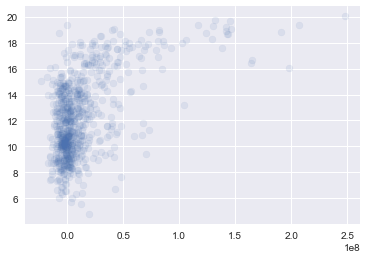

In [553]:
plt.scatter(test_set_pred3,y_test,alpha=.1)
#plt.plot(np.linspace(0,600000,1000),np.linspace(0,600000,1000))

In [ ]:
plt.xlable()

In [81]:
#RMSE
np.sqrt(np.mean((test_set_pred3 - y_test)**2))

29235510.336622018

In [82]:
lr_model3.score(X_test,y_test)

0.45229656652646277

In [83]:
# R-square
r2_score(y_test, test_set_pred3)

0.45229656652646277

In [87]:
#plt.scatter([10,20,30,50],[1,2,3,4])

df3[df3['adj_domestic_sales']]

,title,adj_domestic_sales,domestic_sales,MPAA Rating,Opening Weekend,Production Budget,adj_budget,Runtime,Theaters,Release month,...,Other,Universal,Warner Bros.,Weinstein / Dimension,Well Go USA,Female_Lead,Male_Lead,Genre_Other,Other_Friday,Other_Distributor
0,It,291389250.811,291182790.000,R,nan,35000000.000,35024816.468,135.000,4148.000,9.000,...,1,0,0,0,0,0,0,0,0,1
1,Star Wars: The Force Awakens,953563544.283,936662225.000,PG-13,nan,245000000.000,249420828.676,136.000,4134.000,12.000,...,0,0,0,0,0,0,1,1,0,0
2,Jurassic World,667470531.866,652270625.000,PG-13,nan,150000000.000,153495460.232,124.000,4291.000,6.000,...,0,1,0,0,0,0,1,0,0,0
3,Avengers: Age of Ultron,470240215.678,459005868.000,PG-13,nan,250000000.000,256118847.525,141.000,4276.000,5.000,...,0,0,0,0,0,0,1,0,0,0
4,Inside Out,364698761.094,356461711.000,PG,nan,175000000.000,179043867.046,94.000,4158.000,6.000,...,0,0,0,0,0,1,0,0,0,0
5,Furious 7,361923159.784,353007020.000,PG-13,nan,190000000.000,194798959.973,137.000,4022.000,4.000,...,0,1,0,0,0,0,1,0,0,0
6,Minions,343614282.105,336045770.000,PG,nan,74000000.000,75666647.659,91.000,4311.000,7.000,...,0,1,0,0,0,1,0,0,0,0
7,The Hunger Games: Mockingjay - Part 2,287026391.455,281723902.000,PG-13,nan,160000000.000,163011453.081,137.000,4175.000,11.000,...,0,0,0,0,0,1,0,0,0,0
8,The Martian,233044238.030,228433663.000,PG-13,nan,108000000.000,110179810.527,141.000,3854.000,10.000,...,0,0,0,0,0,0,1,0,0,0
9,Cinderella,206350068.791,201151353.000,PG,nan,95000000.000,97455255.671,112.000,3848.000,3.000,...,0,0,0,0,0,1,0,1,0,0


ValueError: x and y must be the same size

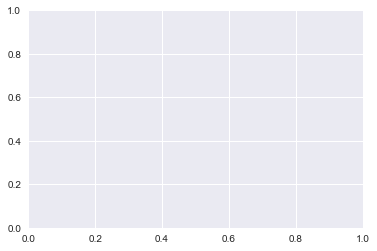

In [91]:
plt.scatter(df3[df3['Runtime']<200],df3['adj_domestic_sales'])

**Multiple Regression 3**

In [94]:
df3['Top_Actor'].value_counts()

0    2509
1      16
Name: Top_Actor, dtype: int64

In [96]:
df3['Runtime_sq'] = df3['Runtime'].apply(lambda x : x**2)
df3['Theaters_sq'] = df3['Theaters'].apply(lambda x : x**2)

In [132]:
#Separate our features from our target

X = df3.loc[:,['G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated',
               'Action','Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance','Romantic Comedy', 'Sci-Fi', 'Thriller', 
        'Not_top_Actor', 'Top_Actor',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec', 
        'Friday', 'Other_Friday', 
         'Theaters','Theaters_sq',
        'Runtime', 'Runtime_sq' ,         
        'Buena Vista','Clarius Entertainment', 'Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal', 'Warner Bros.','Weinstein / Dimension', 'Well Go USA', 'Female_Lead', 'Male_Lead']]
y = df3['adj_domestic_sales']

In [133]:
#Split the data 70-30 train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [134]:
selected_columns_4 = ['G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated',
               'Action','Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance','Romantic Comedy', 'Sci-Fi', 'Thriller', 
        'Not_top_Actor', 'Top_Actor',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec', 
        'Friday', 'Other_Friday', 
         'Theaters','Theaters_sq',
        'Runtime', 'Runtime_sq' ,         
        'Buena Vista','Clarius Entertainment', 'Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal', 'Warner Bros.','Weinstein / Dimension', 'Well Go USA', 'Female_Lead', 'Male_Lead']

In [135]:
# Filling Theater and Runtime square with averages
mean_theatre2 = df3['Theaters_sq'].mean()
mean_runtime2 = df3['Runtime_sq'].mean()

df3['Theaters_sq'] = df3['Theaters_sq'].fillna(value=mean_theatre2)
df3['Runtime_sq'] = df3['Runtime_sq'].fillna(value=mean_runtime2)

In [117]:
df3.isnull().sum()

title                       0
adj_domestic_sales          0
domestic_sales              0
MPAA Rating                 0
Opening Weekend          2525
Production Budget        2229
adj_budget               2229
Runtime                     0
Theaters                    0
Release month               0
Release year                0
Release Date2               0
Genre_Cln                   0
Top _10                  2129
Friday_Vs_Other             0
Top_10_distributor          0
G                           0
NC-17                       0
Not Yet Rated               0
PG                          0
PG-13                       0
R                           0
Unrated                     0
Action                      0
Action / Adventure          0
Action Comedy               0
Animation                   0
Comedy                      0
Comedy / Drama              0
Crime Drama                 0
                         ... 
Feb                         0
Mar                         0
Apr       

In [118]:
y_train.isnull().sum()
X.isnull().sum()

G                           0
NC-17                       0
Not Yet Rated               0
PG                          0
PG-13                       0
R                           0
Unrated                     0
Action                      0
Action / Adventure          0
Action Comedy               0
Animation                   0
Comedy                      0
Comedy / Drama              0
Crime Drama                 0
Documentary                 0
Drama                       0
Drama / Thriller            0
Foreign                     0
Horror                      0
Other_than_Friday        2525
Romance                     0
Romantic Comedy             0
Sci-Fi                      0
Thriller                    0
Not_top_Actor               0
Top_Actor                   0
Jan                         0
Feb                         0
Mar                         0
Apr                         0
May                         0
June                        0
July                        0
Aug       

In [136]:
lr_model4 = LinearRegression()
lr_model4.fit(X_train.loc[:,selected_columns_4],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [137]:
list(zip(selected_columns_4,lr_model4.coef_))

[('G', -11664672.847469036),
 ('NC-17', -3540948.1143344096),
 ('Not Yet Rated', -4853752.3533534054),
 ('PG', 8491358.7041058969),
 ('PG-13', 11872461.783405891),
 ('R', 688004.84702862054),
 ('Unrated', -992476.61817165837),
 ('Action', 34147524.357185766),
 ('Action / Adventure', 61111960.772215843),
 ('Action Comedy', 2113366.6765035745),
 ('Animation', 11678456.370249249),
 ('Comedy', -6378455.1365783252),
 ('Comedy / Drama', -11989113.197222603),
 ('Crime Drama', -12167207.266048197),
 ('Documentary', -5200808.5527773425),
 ('Drama', -9447263.9810912311),
 ('Drama / Thriller', -4402562.2478231397),
 ('Foreign', -7528076.1339548137),
 ('Horror', 3287278.9368564002),
 ('Romance', -8929437.3893723898),
 ('Romantic Comedy', -6899153.8960848432),
 ('Sci-Fi', -5809331.7467210339),
 ('Thriller', -14094073.654202282),
 ('Not_top_Actor', 9678594.9609976336),
 ('Top_Actor', 23006099.049609855),
 ('Jan', -8445198.8203030527),
 ('Feb', -4318922.3984008459),
 ('Mar', 258413.87468009442),
 ('A

In [138]:
test_set_pred4 = lr_model4.predict(X_test.loc[:,selected_columns_4])

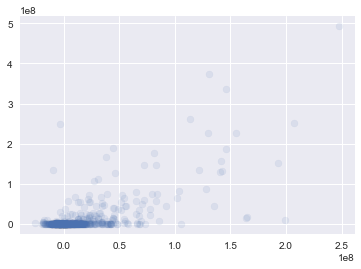

In [139]:
plt.scatter(test_set_pred4,y_test,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,600000,1000))

In [140]:
#RMSE
np.sqrt(np.mean((test_set_pred4 - y_test)**2))

29279032.710837748

In [141]:
# R-square
r2_score(y_test, test_set_pred4)  

0.45066464037676179

I tried adding square terms for Runtime and number of theatres. But, there was no improvement in Rsquare and RMSE. At one instance
infact Rsquare decreased slightly.

I also tried to remove outliers- above 99.9% perentile there were three movies. But, it actually reduced the R-square and increased RMSE of the model.

Multiple Regression with added Top actor column

In [142]:
smaller_movies['Top _10'].unique()

array([nan, 'N', 'Y'], dtype=object)

In [143]:
smaller_movies['Top _10'] = smaller_movies['Top _10'].fillna('N')

In [146]:
df4 = pd.concat([df3,pd.get_dummies(smaller_movies['Top _10'])],axis =1)
df4.head()

,title,adj_domestic_sales,domestic_sales,MPAA Rating,Opening Weekend,Production Budget,adj_budget,Runtime,Theaters,Release month,...,Well Go USA,Female_Lead,Male_Lead,Genre_Other,Other_Friday,Other_Distributor,Runtime_sq,Theaters_sq,N,Y
0,It,291389250.811,291182790.000,R,nan,35000000.000,35024816.468,135.000,4148.000,9.000,...,0.000,0.000,0.000,0.000,0.000,1.000,18225.000,17205904.000,1,0
1,Star Wars: The Force Awakens,953563544.283,936662225.000,PG-13,nan,245000000.000,249420828.676,136.000,4134.000,12.000,...,0.000,0.000,1.000,1.000,0.000,0.000,18496.000,17089956.000,1,0
2,Jurassic World,667470531.866,652270625.000,PG-13,nan,150000000.000,153495460.232,124.000,4291.000,6.000,...,0.000,0.000,1.000,0.000,0.000,0.000,15376.000,18412681.000,1,0
3,Avengers: Age of Ultron,470240215.678,459005868.000,PG-13,nan,250000000.000,256118847.525,141.000,4276.000,5.000,...,0.000,0.000,1.000,0.000,0.000,0.000,19881.000,18284176.000,0,1
4,Inside Out,364698761.094,356461711.000,PG,nan,175000000.000,179043867.046,94.000,4158.000,6.000,...,0.000,1.000,0.000,0.000,0.000,0.000,8836.000,17288964.000,1,0


In [154]:
df4['Runtime_sq'].dropna(axis=0, how ='all') 
df4.isnull().sum()
df5 = df4[pd.notnull(df4['title'])]

In [155]:
#Separate our features from our target

X = df5.loc[:,['Runtime',
       'Theaters', 
       'Other_Friday', 'Friday' , 
       'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead','N','Y']]

y = df5['adj_domestic_sales']

In [156]:
#Split the data 70-30 train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [157]:
selected_columns_6 = [ 
       'Other_Friday', 'Friday',
        'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated',
 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead','N','Y']

In [158]:
df5[selected_columns_6].isnull().sum()

Other_Friday             0
Friday                   0
G                        0
NC-17                    0
Not Yet Rated            0
PG                       0
PG-13                    0
R                        0
Unrated                  0
Action                   0
Action / Adventure       0
Action Comedy            0
Animation                0
Comedy                   0
Comedy / Drama           0
Crime Drama              0
Documentary              0
Drama                    0
Drama / Thriller         0
Foreign                  0
Horror                   0
Romance                  0
Romantic Comedy          0
Sci-Fi                   0
Thriller                 0
Genre_Other              0
Jan                      0
Feb                      0
Mar                      0
Apr                      0
May                      0
June                     0
July                     0
Aug                      0
Sept                     0
Oct                      0
Nov                      0
D

In [159]:
lr_model7 = LinearRegression()
lr_model7.fit(X_train.loc[:,selected_columns_6],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [160]:
test_set_pred5 = lr_model7.predict(X_test.loc[:,selected_columns_6])

In [161]:
#RMSE
np.sqrt(np.mean((test_set_pred5 - y_test)**2))

28909363.380322885

In [162]:
# R-square
r2_score(y_test, test_set_pred5)

0.46444859746048306

In [163]:
df5.isnull().sum()

title                       0
adj_domestic_sales          0
domestic_sales              0
MPAA Rating                 0
Opening Weekend          2525
Production Budget        2229
adj_budget               2229
Runtime                     0
Theaters                    0
Release month               0
Release year                0
Release Date2               0
Genre_Cln                   0
Top _10                  2129
Friday_Vs_Other             0
Top_10_distributor          0
G                           0
NC-17                       0
Not Yet Rated               0
PG                          0
PG-13                       0
R                           0
Unrated                     0
Action                      0
Action / Adventure          0
Action Comedy               0
Animation                   0
Comedy                      0
Comedy / Drama              0
Crime Drama                 0
                         ... 
Apr                         0
May                         0
June      

In [478]:
df3.columns

Index(['title', 'adj_domestic_sales', 'domestic_sales', 'MPAA Rating',
       'Opening Weekend', 'Production Budget', 'adj_budget', 'Runtime',
       'Theaters', 'Release month', 'Release year', 'Release Date2',
       'Genre_Cln', 'Top _10', 'Friday_Vs_Other', 'Top_10_distributor', 'G',
       'NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror', 'Other', 'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Not_top_Actor', 'Top_Actor',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Friday', 'Other', 'Buena Vista', 'Clarius Entertainment',
       'Fox', 'Lionsgate', 'Lionsgate/Summit', 'Other', 'Universal',
       'Warner Bros.', 'Weinstein / Dimension', 'Well Go USA', 'Female_Lead',
       'Male_Lead', 'Genre_Other', 'Other_Friday', 

**Lasso Regression: (without scaling parameters)**

In [164]:
alphavec = 10**np.linspace(-3,9,27) # 10 raise to - vector of alphas
alphavec

array([  1.00000000e-03,   2.89426612e-03,   8.37677640e-03,
         2.42446202e-02,   7.01703829e-02,   2.03091762e-01,
         5.87801607e-01,   1.70125428e+00,   4.92388263e+00,
         1.42510267e+01,   4.12462638e+01,   1.19377664e+02,
         3.45510729e+02,   1.00000000e+03,   2.89426612e+03,
         8.37677640e+03,   2.42446202e+04,   7.01703829e+04,
         2.03091762e+05,   5.87801607e+05,   1.70125428e+06,
         4.92388263e+06,   1.42510267e+07,   4.12462638e+07,
         1.19377664e+08,   3.45510729e+08,   1.00000000e+09])

In [165]:
lr_model8 = LassoCV(alphas = alphavec, cv=5) 
lr_model8.fit(X_train.loc[:,selected_columns_2],y_train)

LassoCV(alphas=array([  1.00000e-03,   2.89427e-03,   8.37678e-03,   2.42446e-02,
         7.01704e-02,   2.03092e-01,   5.87802e-01,   1.70125e+00,
         4.92388e+00,   1.42510e+01,   4.12463e+01,   1.19378e+02,
         3.45511e+02,   1.00000e+03,   2.89427e+03,   8.37678e+03,
         2.42446e+04,   7.01704e+04,   2.03092e+05,   5.87802e+05,
         1.70125e+06,   4.92388e+06,   1.42510e+07,   4.12463e+07,
         1.19378e+08,   3.45511e+08,   1.00000e+09]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [166]:
lr_model8.alpha_

70170.382867038366

In [167]:
selected_columns_2

['Other_Friday',
 'Friday',
 'G',
 'NC-17',
 'Not Yet Rated',
 'PG',
 'PG-13',
 'R',
 'Unrated',
 'Action',
 'Action / Adventure',
 'Action Comedy',
 'Animation',
 'Comedy',
 'Comedy / Drama',
 'Crime Drama',
 'Documentary',
 'Drama',
 'Drama / Thriller',
 'Foreign',
 'Horror',
 'Romance',
 'Romantic Comedy',
 'Sci-Fi',
 'Thriller',
 'Genre_Other',
 'Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'June',
 'July',
 'Aug',
 'Sept',
 'Oct',
 'Nov',
 'Dec',
 'Buena Vista',
 'Clarius Entertainment',
 'Fox',
 'Lionsgate',
 'Lionsgate/Summit',
 'Universal',
 'Warner Bros.',
 'Weinstein / Dimension',
 'Well Go USA',
 'Other_Distributor',
 'Female_Lead',
 'Male_Lead']

In [168]:
list(zip(selected_columns_2,lr_model8.coef_))

[('Other_Friday', -2277449.8930360521),
 ('Friday', 6.65430659512971e-09),
 ('G', -1092952.6360443172),
 ('NC-17', 0.0),
 ('Not Yet Rated', -0.0),
 ('PG', 6268061.5345493518),
 ('PG-13', 11396376.148385227),
 ('R', 0.0),
 ('Unrated', -224613.36776377659),
 ('Action', 36693379.750050262),
 ('Action / Adventure', 66998673.448541343),
 ('Action Comedy', 2772967.0332398866),
 ('Animation', 12888293.736841785),
 ('Comedy', -131408.95293114847),
 ('Comedy / Drama', -5192159.4186095521),
 ('Crime Drama', -0.0),
 ('Documentary', -899547.21482727909),
 ('Drama', -3110369.8812819975),
 ('Drama / Thriller', 0.0),
 ('Foreign', -0.0),
 ('Horror', 5501710.9502181187),
 ('Romance', -0.0),
 ('Romantic Comedy', -0.0),
 ('Sci-Fi', 0.0),
 ('Thriller', -6337641.1799556315),
 ('Genre_Other', 5614512.6376834419),
 ('Jan', -6775771.7062061578),
 ('Feb', -2032799.7531034679),
 ('Mar', 0.0),
 ('Apr', -1713204.7167500074),
 ('May', 0.0),
 ('June', 4143357.3960874546),
 ('July', 2121619.672216767),
 ('Aug', 0.0)

In [169]:
test_set_pred8 = lr_model8.predict(X_test.loc[:,selected_columns_2])

In [170]:
#RMSE
np.sqrt(np.mean((test_set_pred8 - y_test)**2))

28983306.348283451

In [171]:
lr_model9 = LassoCV(alphas = alphavec, cv=5) 
lr_model9.fit(X_train.loc[:,selected_columns_3],y_train)

LassoCV(alphas=array([  1.00000e-03,   2.89427e-03,   8.37678e-03,   2.42446e-02,
         7.01704e-02,   2.03092e-01,   5.87802e-01,   1.70125e+00,
         4.92388e+00,   1.42510e+01,   4.12463e+01,   1.19378e+02,
         3.45511e+02,   1.00000e+03,   2.89427e+03,   8.37678e+03,
         2.42446e+04,   7.01704e+04,   2.03092e+05,   5.87802e+05,
         1.70125e+06,   4.92388e+06,   1.42510e+07,   4.12463e+07,
         1.19378e+08,   3.45511e+08,   1.00000e+09]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [172]:
lr_model9.alpha_

70170.382867038366

In [173]:
list(zip(X_train.columns,lr_model9.coef_))

[('Runtime', 113450.09641940874),
 ('Theaters', -218.83381121333159),
 ('Other_Friday', -2093104.2723138051),
 ('Friday', 6.2846228954002813e-09),
 ('G', -0.0),
 ('NC-17', -0.0),
 ('Not Yet Rated', -0.0),
 ('PG', 6909554.1714483239),
 ('PG-13', 11674921.575194467),
 ('R', 0.0),
 ('Unrated', -1756776.2157298825),
 ('Action', 35599219.737236626),
 ('Action / Adventure', 65771501.387379341),
 ('Action Comedy', 1531241.6346226018),
 ('Animation', 14938693.330720359),
 ('Comedy', -0.0),
 ('Comedy / Drama', -4886877.5850765482),
 ('Crime Drama', -0.0),
 ('Documentary', -0.0),
 ('Drama', -3214679.5128481719),
 ('Drama / Thriller', 0.0),
 ('Foreign', -354239.90454912232),
 ('Horror', 6401555.0583162382),
 ('Romance', -0.0),
 ('Romantic Comedy', -0.0),
 ('Sci-Fi', 0.0),
 ('Thriller', -6494687.1177025829),
 ('Genre_Other', 5426910.0480569741),
 ('Jan', -6813822.4191936981),
 ('Feb', -2620764.6599160824),
 ('Mar', 0.0),
 ('Apr', -1359395.6614754891),
 ('May', -0.0),
 ('June', 3991017.816918035),


**Model on Logarithmic scale:**

In [174]:
df5['log_adj_domestic_sales'] = df5['adj_domestic_sales'].apply( lambda x : np.log(x))

/Users/pradnyanimkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [188]:
#Separate our features from our target

X = df5.loc[:,[
       'Other_Friday', 'Friday' , 
       'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead']]

y = df5['log_adj_domestic_sales']

selected_columns_7 = [
       'Other_Friday', 'Friday' , 
       'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead']

In [184]:
df5['adj_domestic_sales'].describe()

count        2525.000
mean     12752371.568
std      50210044.368
min            75.508
25%         19428.305
50%        124928.803
75%       1810205.385
max     953563544.283
Name: adj_domestic_sales, dtype: float64

In [185]:
df5['log_adj_domestic_sales'].describe()

count   2525.000
mean      12.281
std        3.113
min        4.324
25%        9.874
50%       11.735
75%       14.409
max       20.676
Name: log_adj_domestic_sales, dtype: float64

In [186]:
#Split the data 70-30 train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [189]:
lr_model11 = LinearRegression()
lr_model11.fit(X_train.loc[:,selected_columns_7],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [180]:
y.isnull().sum()

0

In [190]:
test_set_pred11 = lr_model11.predict(X_test.loc[:,selected_columns_7])

In [191]:
#RMSE
np.sqrt(np.mean((test_set_pred11 - y_test)**2))

2.1848520631153767

In [194]:
np.exp(2.18)  => #%The error is 884%*

8.8463062587208832

In [195]:
# R-square
r2_score(y_test, test_set_pred11)

0.48989327279666695

**Lasso on Log Scale**

In [204]:
alphavec2 = 10**np.linspace(-5,3,40) # 10 raise to - vector of alphas
alphavec2

array([  1.00000000e-05,   1.60371874e-05,   2.57191381e-05,
         4.12462638e-05,   6.61474064e-05,   1.06081836e-04,
         1.70125428e-04,   2.72833338e-04,   4.37547938e-04,
         7.01703829e-04,   1.12533558e-03,   1.80472177e-03,
         2.89426612e-03,   4.64158883e-03,   7.44380301e-03,
         1.19377664e-02,   1.91448198e-02,   3.07029063e-02,
         4.92388263e-02,   7.89652287e-02,   1.26638017e-01,
         2.03091762e-01,   3.25702066e-01,   5.22334507e-01,
         8.37677640e-01,   1.34339933e+00,   2.15443469e+00,
         3.45510729e+00,   5.54102033e+00,   8.88623816e+00,
         1.42510267e+01,   2.28546386e+01,   3.66524124e+01,
         5.87801607e+01,   9.42668455e+01,   1.51177507e+02,
         2.42446202e+02,   3.88815518e+02,   6.23550734e+02,
         1.00000000e+03])

In [205]:
lr_model9 = LassoCV(alphas = alphavec2, cv=5) 
lr_model9.fit(X_train.loc[:,selected_columns_2],y_train)

LassoCV(alphas=array([  1.00000e-05,   1.60372e-05,   2.57191e-05,   4.12463e-05,
         6.61474e-05,   1.06082e-04,   1.70125e-04,   2.72833e-04,
         4.37548e-04,   7.01704e-04,   1.12534e-03,   1.80472e-03,
         2.89427e-03,   4.64159e-03,   7.44380e-03,   1.19378e-02,
         1.91448e-02,   3...1,   9.42668e+01,   1.51178e+02,
         2.42446e+02,   3.88816e+02,   6.23551e+02,   1.00000e+03]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [206]:
lr_model9.alpha_

0.0046415888336127772

In [207]:
list(zip(selected_columns_2,lr_model9.coef_))

[('Other_Friday', 0.5742074377442935),
 ('Friday', -8.9549693805002961e-15),
 ('G', 0.0),
 ('NC-17', -0.0),
 ('Not Yet Rated', -0.78288163513210218),
 ('PG', 1.0340560560657934),
 ('PG-13', 1.0747453291200235),
 ('R', -0.0),
 ('Unrated', -1.3996584419928111),
 ('Action', 0.52975138132023969),
 ('Action / Adventure', 0.45360718399395106),
 ('Action Comedy', 1.0108317320433675),
 ('Animation', 0.50957419723385144),
 ('Comedy', 0.0),
 ('Comedy / Drama', -0.52323383388969491),
 ('Crime Drama', -0.62235209546401737),
 ('Documentary', -0.7108145049824417),
 ('Drama', -0.45244401984453186),
 ('Drama / Thriller', -0.0),
 ('Foreign', -0.089618360963478319),
 ('Horror', 0.15618181428117112),
 ('Romance', 0.0),
 ('Romantic Comedy', 0.0),
 ('Sci-Fi', 0.0),
 ('Thriller', -0.80492818297918112),
 ('Genre_Other', -0.0049929609894076715),
 ('Jan', -0.17090194888926036),
 ('Feb', 0.4161862813790399),
 ('Mar', -0.042438898964470242),
 ('Apr', 0.0),
 ('May', -0.16760571000121291),
 ('June', 0.069233956315

In [208]:
test_set_pred9 = lr_model9.predict(X_test.loc[:,selected_columns_2])

In [209]:
#RMSE
np.sqrt(np.mean((test_set_pred9 - y_test)**2))

2.1839991479028744

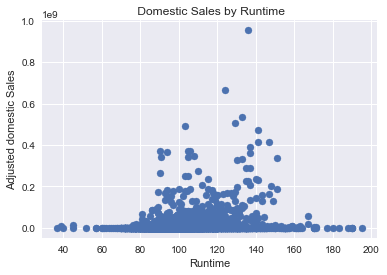

In [546]:
plt.scatter(df5[df5['Runtime']<200]['Runtime'],df5[df5['Runtime']<200]['adj_domestic_sales'])
plt.xlabel('Runtime')
plt.ylabel('Adjusted domestic Sales')
plt.title(' Domestic Sales by Runtime')

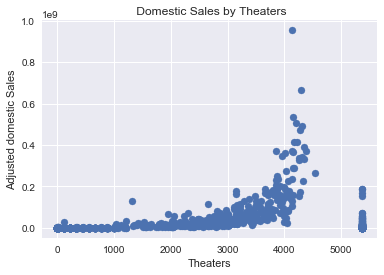

In [547]:
plt.scatter(df5[df5['Theaters']<10000]['Theaters'],df5[df5['Theaters']<10000]['adj_domestic_sales'])
plt.xlabel('Theaters')
plt.ylabel('Adjusted domestic Sales')
plt.title(' Domestic Sales by Theaters')

In [213]:
df5['Theaters'].describe()

count    2525.000
mean     5368.235
std     12334.100
min         1.000
25%         7.000
50%       338.000
75%      5368.235
max     92925.000
Name: Theaters, dtype: float64

Adding quadratic effects of Theaters and Runtime in logarithmic Lasso

In [219]:
#Separate our features from our target

X2 = df5.loc[:,[
       'Runtime','Runtime_sq','Theaters', 'Theaters_sq',
       'Other_Friday', 'Friday' , 
       'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead','N','Y']]

y2 = df5['log_adj_domestic_sales']

In [220]:
selected_columns_8 = ['Runtime','Runtime_sq','Theaters', 'Theaters_sq',
       'Other_Friday', 'Friday' , 
       'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead','N','Y']

In [223]:
#Split the data 70-30 train/test

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3,random_state=42)

In [228]:
lr_model12 = LassoCV(alphas = alphavec2, cv=5) 
lr_model12.fit(X2_train.loc[:,selected_columns_8],y2_train)

LassoCV(alphas=array([  1.00000e-05,   1.60372e-05,   2.57191e-05,   4.12463e-05,
         6.61474e-05,   1.06082e-04,   1.70125e-04,   2.72833e-04,
         4.37548e-04,   7.01704e-04,   1.12534e-03,   1.80472e-03,
         2.89427e-03,   4.64159e-03,   7.44380e-03,   1.19378e-02,
         1.91448e-02,   3...1,   9.42668e+01,   1.51178e+02,
         2.42446e+02,   3.88816e+02,   6.23551e+02,   1.00000e+03]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [229]:
lr_model12.alpha_

0.011937766417144358

In [230]:
list(zip(selected_columns_7,lr_model12.coef_))

[('Runtime', 0.040082881881923611),
 ('Runtime_sq', -5.2723268956945714e-05),
 ('Theaters', 0.0001266856882561106),
 ('Theaters_sq', -1.4250081675599563e-09),
 ('Other_Friday', 0.10641647900468353),
 ('Friday', -9.6953408647148892e-16),
 ('G', 0.0),
 ('NC-17', -0.0),
 ('Not Yet Rated', -0.0),
 ('PG', 0.99436197553449812),
 ('PG-13', 0.83950928624286603),
 ('R', -0.0),
 ('Unrated', -1.2608546934532634),
 ('Action', 0.18012284656029059),
 ('Action / Adventure', 0.0),
 ('Action Comedy', 0.28481126828672548),
 ('Animation', 0.62077882144434204),
 ('Comedy', 0.17076575217121143),
 ('Comedy / Drama', -0.22320070593753724),
 ('Crime Drama', -0.0),
 ('Documentary', -0.020400241439568745),
 ('Drama', -0.36438727671029703),
 ('Drama / Thriller', 0.0),
 ('Foreign', -0.0),
 ('Horror', 0.50119056676330875),
 ('Romance', 0.0),
 ('Romantic Comedy', -0.0),
 ('Sci-Fi', 0.0),
 ('Thriller', -0.38658430012484712),
 ('Genre_Other', -0.0040014264650246696),
 ('Jan', -0.05455906848833602),
 ('Feb', 0.2305312

In [231]:
test_set_pred12 = lr_model12.predict(X2_test.loc[:,selected_columns_8])

In [248]:
#RMSE
np.sqrt(np.mean((test_set_pred12 - y2_test)**2))

2.0056084075721547

In [249]:
# R-square
r2_score(y2_test, test_set_pred12)

0.57015759071492711

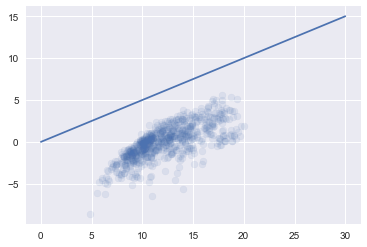

In [263]:
# Adding a residual plot 
plt.scatter(y2_test,y2_test-test_set_pred12,alpha=.1)
plt.plot(np.linspace(0,30,10000),np.linspace(0,15,10000))

In [256]:
[y2_test,y2_test-test_set_pred12]

[1954   15.783
 749    15.328
 194    14.336
 963    11.571
 1326   18.268
 170    14.828
 1653   10.260
 648     8.401
 2038   13.982
 1138    9.716
 2487    8.430
 2026   14.247
 531     9.791
 1456   14.051
 2107   12.769
 251    13.259
 2500    7.970
 1331   18.121
 2469    8.814
 321    12.270
 1602   11.145
 1736    9.028
 134    15.896
 1390   15.914
 499    10.132
 1084   10.309
 1624   10.754
 1594   11.347
 1750    8.806
 858    13.004
         ...  
 2476    8.659
 2088   13.127
 643     8.464
 1727    9.222
 311    12.392
 351    11.950
 549     9.614
 2321   10.302
 1560   11.981
 1160    9.441
 306    12.557
 287    12.794
 695     6.572
 1559   11.987
 631     8.591
 2061   13.535
 1862   17.923
 2444    9.146
 1436   14.422
 1477   13.475
 791    14.291
 1633   10.628
 1508   12.889
 1611   10.866
 1656   10.193
 1562   11.949
 1187    9.170
 13     19.046
 1394   15.781
 1449   14.237
 Name: log_adj_domestic_sales, Length: 758, dtype: float64, 1954    0.088
 749     1.

**Random Forest with log y**

In [235]:
feature_columns = ['Runtime','Runtime_sq','Theaters', 'Theaters_sq',
       'Other_Friday', 'Friday' , 
       'G','NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror',  'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Genre_Other',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct','Nov', 'Dec',
        'Buena Vista', 'Clarius Entertainment','Fox', 'Lionsgate', 'Lionsgate/Summit', 'Universal','Warner Bros.', 'Weinstein / Dimension', 'Well Go USA','Other_Distributor' ,
        'Female_Lead','Male_Lead','N','Y']

y3 = df5.loc[:,'log_adj_domestic_sales']
X3 = df5.loc[:,feature_columns]

In [281]:
#Split the data 70-30 train/test

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3)#,random_state=42)

In [282]:
## To start, we will build a single tree
from sklearn import tree

# Set some parameters
#dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=4)
dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=6, min_samples_leaf=8)

# Fit the model to some training data
dtrmodel.fit(X3_train,y3_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=8, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [238]:
dtrmodel.tree_

In [239]:
# Export the structure of the tree to a file

tree.export_graphviz(dtrmodel, out_file='tree1.dot',feature_names = X3_train.columns)

In [240]:
# Look at the file (using ! for a command line access)

!head tree1.dot

digraph Tree {
node [shape=box] ;
0 [label="Theaters <= 552.5\nmse = 9.8206\nsamples = 1767\nvalue = 12.3141"] ;
1 [label="Theaters <= 111.5\nmse = 2.6904\nsamples = 946\nvalue = 10.3605"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Theaters_sq <= 12.5\nmse = 1.8753\nsamples = 590\nvalue = 9.6077"] ;
1 -> 2 ;
3 [label="Theaters_sq <= 2.5\nmse = 1.2472\nsamples = 296\nvalue = 8.9289"] ;
2 -> 3 ;
4 [label="Foreign <= 0.5\nmse = 1.2744\nsamples = 120\nvalue = 8.4733"] ;


In [241]:
list(zip(dtrmodel.tree_.feature,dtrmodel.tree_.threshold))[:10]

[(2, 552.5),
 (2, 111.5),
 (3, 12.5),
 (3, 2.5),
 (23, 0.5),
 (17, 0.5),
 (-2, -2.0),
 (-2, -2.0),
 (0, 104.5),
 (-2, -2.0)]

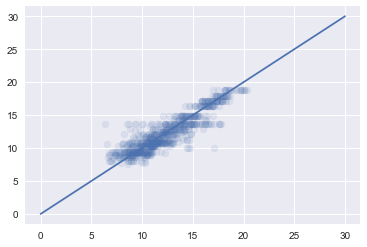

In [283]:
# Now let's predict on the test set and plot pred vs actual

tree_pred_test = dtrmodel.predict(X3_test)
plt.scatter(y3_test, tree_pred_test,alpha=.1)
plt.plot(np.linspace(0,30,1000),np.linspace(0,30,1000))

In [262]:
# Root Mean Square Error (compared to 2.00 for linear regression )
np.sqrt(np.mean((tree_pred_test - y3_test)**2))

1.4167869940305882

In [264]:
np.exp(1.4) => 400%

4.0551999668446745

In [284]:
# R-square
r2_score(y3_test, tree_pred_test)

0.8037783292741828

In [285]:
from sklearn.ensemble import RandomForestRegressor

In [286]:
# Initialize the model, then fit it on the training data
rfmodel1 = RandomForestRegressor(n_estimators = 500, min_samples_leaf=5, max_features=4, n_jobs=-1)
rfmodel1.fit(X3_train,y3_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [287]:
# Use the trained model to predict the results on the test set
rf1_test_pred = rfmodel1.predict(X3_test)

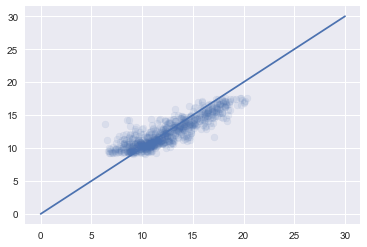

In [288]:
#Plot actual vs predicted
plt.scatter(y3_test, rf1_test_pred,alpha=.1)
plt.plot(np.linspace(0,30,1000),np.linspace(0,30,1000))

In [289]:
# Root Mean Square Error (compared to 34427 for linear regression without OQ2, 29882 with OQ2)
np.sqrt(np.mean((rf1_test_pred - y3_test)**2))

1.5118293842813371

In [290]:
# R-square
r2_score(y3_test,rf1_test_pred )

0.75255483126027289

In [275]:
rfmodel2=RandomForestRegressor(n_estimators = 1000, min_samples_leaf=1,  n_jobs=-1, max_features=4, min_impurity_split=300000) #Your parameters inside the parentheses
rfmodel2.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_split=300000,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [276]:
rf2_test_pred = rfmodel2.predict(X3_test)

ValueError: Number of features of the model must match the input. Model n_features is 50 and input n_features is 56 

In [310]:
df5['Genre_Cln'].unique()
#df5['MPAA Rating'].unique()
#df5['Top _10'].unique()
#df5['Release month'].unique()
#df5['Friday_Vs_Other'].unique()
#df5['Top_10_distributor'].unique()
#df5.columns

array(['Horror', 'Other', 'Action / Adventure', 'Animation', 'Action',
       'Sci-Fi', 'Comedy', 'Romance', 'Drama', 'Action Comedy', 'Thriller',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Foreign',
       'Romantic Comedy', 'Drama / Thriller'], dtype=object)

In [346]:
dict_dfs['MPAA Rating']

,order,MPAA Rating,log_adj_domestic_sales,order_{}.format(i)
0,0,NC-17,9.293,1
1,1,Unrated,10.662,2
2,2,Not Yet Rated,10.972,3
3,3,R,13.102,4
4,4,G,14.670,5
5,5,PG,14.800,6
6,6,PG-13,14.895,7


In [371]:
df6 = df5
df5.shape
df5.columns

Index(['title', 'adj_domestic_sales', 'domestic_sales', 'MPAA Rating',
       'Opening Weekend', 'Production Budget', 'adj_budget', 'Runtime',
       'Theaters', 'Release month', 'Release year', 'Release Date2',
       'Genre_Cln', 'Top _10', 'Friday_Vs_Other', 'Top_10_distributor', 'G',
       'NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror', 'Other', 'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Not_top_Actor', 'Top_Actor',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Friday', 'Other', 'Buena Vista', 'Clarius Entertainment',
       'Fox', 'Lionsgate', 'Lionsgate/Summit', 'Other', 'Universal',
       'Warner Bros.', 'Weinstein / Dimension', 'Well Go USA', 'Female_Lead',
       'Male_Lead', 'Genre_Other', 'Other_Friday', 

In [366]:
df6['r_Genre_Cln'] = df6['Genre_Cln'].map(lambda rating: df6.groupby(['Genre_Cln']).log_adj_domestic_sales.mean().sort_values().index.get_loc(rating)+1)

/Users/pradnyanimkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [372]:
df6['r_Release month'] = df6['Release month'].map(lambda rating: df6.groupby(['Release month']).log_adj_domestic_sales.mean().sort_values().index.get_loc(rating)+1)

/Users/pradnyanimkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [362]:
df6['r_mpaa_rating'] = df6['MPAA Rating'].map(lambda rating: df6.groupby(['MPAA Rating']).log_adj_domestic_sales.mean().sort_values().index.get_loc(rating)+1)

/Users/pradnyanimkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [373]:
df6['r_Friday_Vs_Other'] = df6['Friday_Vs_Other'].map(lambda rating: df6.groupby(['Friday_Vs_Other']).log_adj_domestic_sales.mean().sort_values().index.get_loc(rating)+1)

/Users/pradnyanimkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [378]:
df6['r_Top_10_distributor'] = df6['Top_10_distributor'].map(lambda rating: df6.groupby(['Top_10_distributor']).log_adj_domestic_sales.mean().sort_values().index.get_loc(rating)+1)

/Users/pradnyanimkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [384]:
df6['Top _10'] = df6['Top _10'].fillna(value= 'N')
# Assuming if we don't have name of an actor the movie does not have top actors
df6['r_Top _10'] = df6['Top _10'].map(lambda rating: df6.groupby(['Top _10']).log_adj_domestic_sales.mean().sort_values().index.get_loc(rating)+1)

/Users/pradnyanimkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/pradnyanimkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [385]:
df6.columns

Index(['title', 'adj_domestic_sales', 'domestic_sales', 'MPAA Rating',
       'Opening Weekend', 'Production Budget', 'adj_budget', 'Runtime',
       'Theaters', 'Release month', 'Release year', 'Release Date2',
       'Genre_Cln', 'Top _10', 'Friday_Vs_Other', 'Top_10_distributor', 'G',
       'NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror', 'Other', 'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Not_top_Actor', 'Top_Actor',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Friday', 'Other', 'Buena Vista', 'Clarius Entertainment',
       'Fox', 'Lionsgate', 'Lionsgate/Summit', 'Other', 'Universal',
       'Warner Bros.', 'Weinstein / Dimension', 'Well Go USA', 'Female_Lead',
       'Male_Lead', 'Genre_Other', 'Other_Friday', 

In [386]:
feature_columns2 = ['Runtime','Runtime_sq','Theaters', 'Theaters_sq',
       'r_mpaa_rating', 'r_Genre_Cln', 'r_Release month', 'r_Friday_Vs_Other',
       'r_Top_10_distributor', 'r_Top _10','N','Y']

y4 = df6.loc[:,'log_adj_domestic_sales']
X4 = df6.loc[:,feature_columns2]

In [389]:
#Split the data 70-30 train/test

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3)#,random_state=42)

In [392]:
## To start, we will build a single tree
from sklearn import tree

# Set some parameters

dtrmodel1 = tree.DecisionTreeRegressor(min_samples_split=10, max_depth= 10, min_samples_leaf=8)

# Fit the model to some training data
dtrmodel1.fit(X4_train,y4_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=8, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [393]:
# Export the structure of the tree to a file

tree.export_graphviz(dtrmodel1, out_file='tree2.dot',feature_names = X4_train.columns)

In [394]:
dtrmodel1.tree_

In [395]:
# Look at the file (using ! for a command line access)

!head tree2.dot

digraph Tree {
node [shape=box] ;
0 [label="Theaters <= 332.5\nmse = 9.9141\nsamples = 1767\nvalue = 12.3614"] ;
1 [label="Theaters_sq <= 12.5\nmse = 2.4366\nsamples = 846\nvalue = 10.1779"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Theaters <= 1.5\nmse = 1.3506\nsamples = 301\nvalue = 8.9605"] ;
1 -> 2 ;
3 [label="Runtime <= 86.5\nmse = 1.5129\nsamples = 117\nvalue = 8.5589"] ;
2 -> 3 ;
4 [label="r_Release month <= 3.5\nmse = 0.9484\nsamples = 31\nvalue = 8.1064"] ;


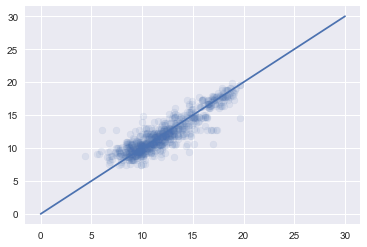

In [396]:
# Now let's predict on the test set and plot pred vs actual

tree_pred_test = dtrmodel1.predict(X4_test)
plt.scatter(y4_test, tree_pred_test,alpha=.1)
plt.plot(np.linspace(0,30,1000),np.linspace(0,30,1000))

In [397]:
# Root Mean Square Error (compared to 2.00 for linear regression )
np.sqrt(np.mean((tree_pred_test - y4_test)**2))

1.3761780377381128

In [398]:
# R-square
r2_score(y4_test, tree_pred_test)

0.79184108134239339

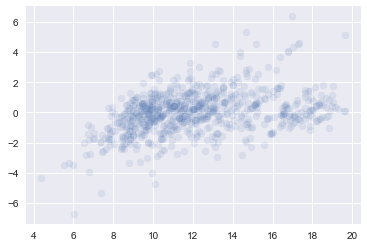

In [467]:
# Adding a residual plot 
plt.scatter(y4_test,y4_test-tree_pred_test,alpha=.1)
#plt.plot(np.linspace(0,30,10000),np.linspace(0,15,10000))

Random Forests:

In [494]:
rfmodel3=RandomForestRegressor(n_estimators = 2000, min_samples_leaf=5,  n_jobs=-1, max_features=5) #Your parameters inside the parentheses
rfmodel3.fit(X4_train,y4_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [495]:
rf3_test_pred = rfmodel3.predict(X4_test)

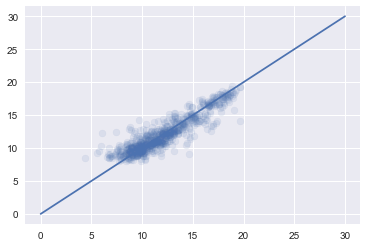

In [496]:
#Plot actual vs predicted
plt.scatter(y4_test, rf3_test_pred,alpha=.1)
plt.plot(np.linspace(0,30,1000),np.linspace(0,30,1000))

In [497]:
np.sqrt(np.mean((rf3_test_pred - y4_test)**2))

1.2713695443023529

In [498]:
# R-square
r2_score(y4_test,rf3_test_pred )

0.82234011154737252

In [516]:
list(zip(X4_train.columns,rfmodel3.feature_importances_))

[('Runtime', 0.026898311552874258),
 ('Runtime_sq', 0.027694817840369229),
 ('Theaters', 0.34881070896479149),
 ('Theaters_sq', 0.35057019348476504),
 ('r_mpaa_rating', 0.10771402285134155),
 ('r_Genre_Cln', 0.02723144741957078),
 ('r_Release month', 0.011682467731041033),
 ('r_Friday_Vs_Other', 0.0046859695016104198),
 ('r_Top_10_distributor', 0.094630377070700114),
 ('r_Top _10', 1.8782034734434276e-05),
 ('N', 3.2415248855952854e-05),
 ('Y', 3.0486299346261211e-05)]

**Gradient Boosting Method**

In [417]:
from sklearn.ensemble import GradientBoostingRegressor

In [488]:
gbmodel1 = GradientBoostingRegressor(n_estimators = 1000, max_depth = 5, learning_rate = .005, subsample = .9) #max_depth is one of the important parameters, n_estimator and learning rate

In [489]:
gbmodel1.fit(X4_train, y4_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.005, loss='ls', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=0.9, verbose=0, warm_start=False)

In [490]:
y_pred_gb1 = gbmodel1.predict(X4_test)

In [491]:
np.sqrt(np.mean((y_pred_gb1 - y4_test)** 2))

1.2737303132033595

In [492]:
list(zip(X4_train.columns,gbmodel1.feature_importances_))

[('Runtime', 0.088850094871822105),
 ('Runtime_sq', 0.090695324376362713),
 ('Theaters', 0.24538743407331443),
 ('Theaters_sq', 0.2679705127607025),
 ('r_mpaa_rating', 0.087108271674892587),
 ('r_Genre_Cln', 0.078713218820756686),
 ('r_Release month', 0.072982872116454933),
 ('r_Friday_Vs_Other', 0.025049692280662901),
 ('r_Top_10_distributor', 0.039852715727183144),
 ('r_Top _10', 0.0010998414204135751),
 ('N', 0.0014530525984290592),
 ('Y', 0.00083696927900528276)]

In [493]:
# R-square
r2_score(y4_test,y_pred_gb1 )

0.82167971608606549

**Single Tree again!**

In [499]:
feature_columns3 = ['Runtime','Theaters',
       'r_mpaa_rating', 'r_Genre_Cln', 'r_Release month', 'r_Friday_Vs_Other',
       'r_Top_10_distributor', 'r_Top _10']

y5 = df6.loc[:,'log_adj_domestic_sales']
X5 = df6.loc[:,feature_columns3]

In [500]:
#Split the data 70-30 train/test

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.3)#,random_state=42)

In [502]:
dtrmodel3 = tree.DecisionTreeRegressor(min_samples_split=10, max_depth= 10, min_samples_leaf=8)

# Fit the model to some training data
dtrmodel3.fit(X5_train,y5_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=8, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [503]:
# Export the structure of the tree to a file

tree.export_graphviz(dtrmodel3, out_file='tree3.dot',feature_names = X5_train.columns)

In [504]:
dtrmodel3.tree_

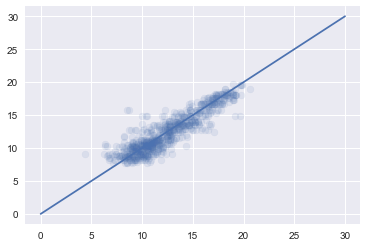

In [505]:
# Now let's predict on the test set and plot pred vs actual

tree_pred_test2 = dtrmodel3.predict(X5_test)
plt.scatter(y5_test, tree_pred_test2,alpha=.1)
plt.plot(np.linspace(0,30,1000),np.linspace(0,30,1000))

In [506]:

np.sqrt(np.mean((tree_pred_test2 - y5_test)**2))

1.3820832625401061

In [507]:
# R-square
r2_score(y5_test,tree_pred_test2 )

0.80898885501053697

**Random Forests again!!**

In [517]:
rfmodel4=RandomForestRegressor(n_estimators = 2000, min_samples_leaf=5,  n_jobs=-1, max_features=5) #Your parameters inside the parentheses
rfmodel4.fit(X5_train,y5_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [519]:
rf4_test_pred = rfmodel4.predict(X5_test)

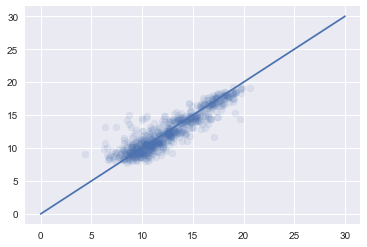

In [520]:
#Plot actual vs predicted
plt.scatter(y5_test, rf4_test_pred,alpha=.1)
plt.plot(np.linspace(0,30,1000),np.linspace(0,30,1000))

In [521]:
np.sqrt(np.mean((rf4_test_pred - y5_test)** 2))

1.3224367728762432

In [522]:
# R-square
r2_score(y5_test,rf4_test_pred )

0.8251200070817909

In [527]:
df6.columns

Index(['title', 'adj_domestic_sales', 'domestic_sales', 'MPAA Rating',
       'Opening Weekend', 'Production Budget', 'adj_budget', 'Runtime',
       'Theaters', 'Release month', 'Release year', 'Release Date2',
       'Genre_Cln', 'Top _10', 'Friday_Vs_Other', 'Top_10_distributor', 'G',
       'NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror', 'Other', 'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Not_top_Actor', 'Top_Actor',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Friday', 'Other', 'Buena Vista', 'Clarius Entertainment',
       'Fox', 'Lionsgate', 'Lionsgate/Summit', 'Other', 'Universal',
       'Warner Bros.', 'Weinstein / Dimension', 'Well Go USA', 'Female_Lead',
       'Male_Lead', 'Genre_Other', 'Other_Friday', 

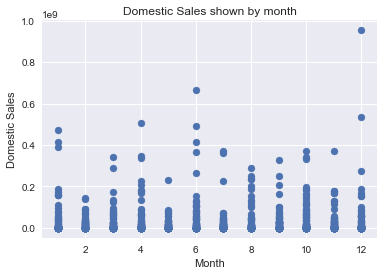

In [533]:
plt.scatter(df6['Release month'],df6['adj_domestic_sales'])
plt.xlabel('Month')
plt.ylabel('Domestic Sales')
plt.title('Domestic Sales shown by month')

/Users/pradnyanimkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


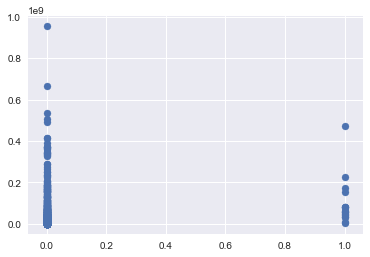

In [545]:
df6['Top_10_coded'] = df6['Top _10'].apply(lambda x : 1 if x == "Y" else 0) # 1 is Y
#sns.stripplot(x = 'Top _10', y = 'adj_domestic_sales', data = df6)
#df6['adj_domestic_sales']
plt.scatter(df6['Top_10_coded'],df6['adj_domestic_sales'])

In [537]:
plt.scatter(df6['Top _10'],df6['adj_domestic_sales'])
plt.xlabel('Top 10 Actors')
plt.ylabel('Domestic Sales')
plt.title('Domestic Sales shown by Top 10 Actors')
                               

ValueError: could not convert string to float: 'N'

ValueError: could not convert string to float: 'N'

In [524]:
df6.columns

Index(['title', 'adj_domestic_sales', 'domestic_sales', 'MPAA Rating',
       'Opening Weekend', 'Production Budget', 'adj_budget', 'Runtime',
       'Theaters', 'Release month', 'Release year', 'Release Date2',
       'Genre_Cln', 'Top _10', 'Friday_Vs_Other', 'Top_10_distributor', 'G',
       'NC-17', 'Not Yet Rated', 'PG', 'PG-13', 'R', 'Unrated', 'Action',
       'Action / Adventure', 'Action Comedy', 'Animation', 'Comedy',
       'Comedy / Drama', 'Crime Drama', 'Documentary', 'Drama',
       'Drama / Thriller', 'Foreign', 'Horror', 'Other', 'Romance',
       'Romantic Comedy', 'Sci-Fi', 'Thriller', 'Not_top_Actor', 'Top_Actor',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Friday', 'Other', 'Buena Vista', 'Clarius Entertainment',
       'Fox', 'Lionsgate', 'Lionsgate/Summit', 'Other', 'Universal',
       'Warner Bros.', 'Weinstein / Dimension', 'Well Go USA', 'Female_Lead',
       'Male_Lead', 'Genre_Other', 'Other_Friday', 

In [560]:
df6['title']['log_adj_domestic_sales'].min()

KeyError: 'log_adj_domestic_sales'

In [561]:
df6.loc[df6['log_adj_domestic_sales'].idxmax()]

title                     Star Wars: The Force Awakens
adj_domestic_sales                       953563544.283
domestic_sales                           936662225.000
MPAA Rating                                      PG-13
Opening Weekend                                    NaN
Production Budget                        245000000.000
adj_budget                               249420828.676
Runtime                                        136.000
Theaters                                      4134.000
Release month                                       12
Release year                                  2015.000
Release Date2                      2015-12-18 00:00:00
Genre_Cln                                        Other
Top _10                                              N
Friday_Vs_Other                                 Friday
Top_10_distributor                         Buena Vista
G                                                0.000
NC-17                                            0.000
Not Yet Ra

In [562]:
df6.loc[df6['log_adj_domestic_sales'].idxmin()]

title                     Confession of a Child of the Century
adj_domestic_sales                                      75.508
domestic_sales                                          74.000
MPAA Rating                                            Unrated
Opening Weekend                                            NaN
Production Budget                                          NaN
adj_budget                                                 NaN
Runtime                                                120.000
Theaters                                                 1.000
Release month                                                3
Release year                                          2015.000
Release Date2                              2015-09-25 00:00:00
Genre_Cln                                                Drama
Top _10                                                      N
Friday_Vs_Other                                         Friday
Top_10_distributor                                     

In [568]:
import ml_insights as mli

In [567]:
dir(ml_insights)

['ModelXRay',
 'SplineCalibratedClassifierCV',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'calibration',
 'calibration_utils',
 'compact_logit',
 'insights',
 'metrics',
 'plot_prob_calibration',
 'plot_reliability_diagram',
 'prob_calibration_function',
 'prob_calibration_function_multiclass',
 'train_and_calibrate_cv',
 'utils']

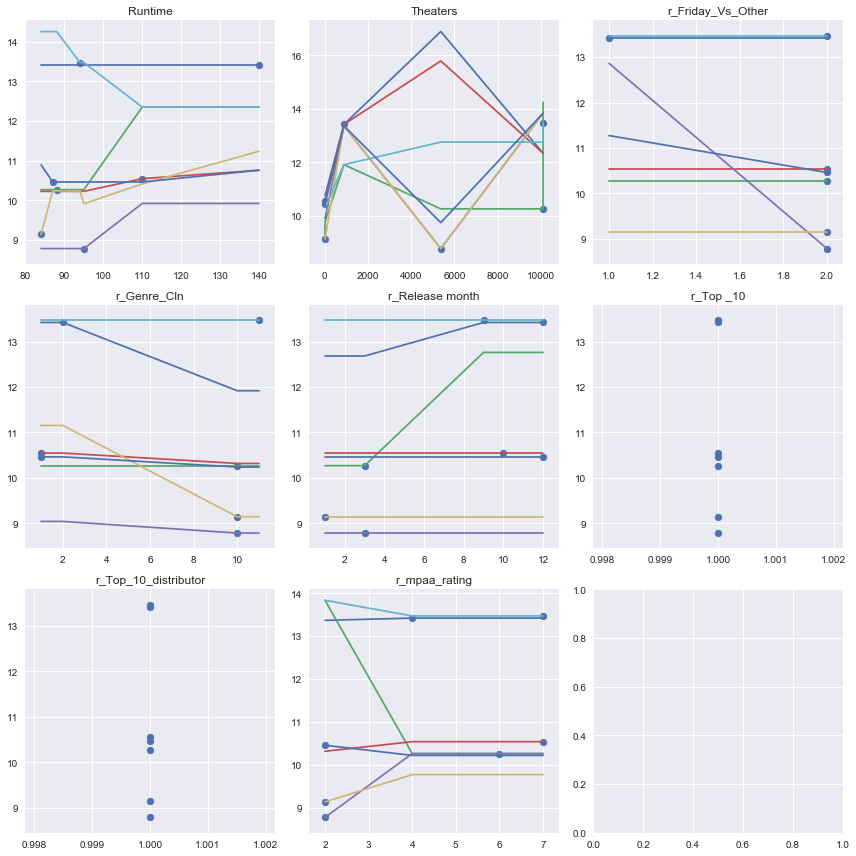

In [573]:
movie_test = X5_test.sample(500)
mtr = mli.ModelXRay(dtrmodel3,movie_test[:7])
mliindices = mtr.feature_dependence_plots(pts_selected=np.arange(7))
plt.show()

In [570]:
list(zip(X5_train.columns,dtrmodel3.feature_importances_))

[('Runtime', 0.023739874315722397),
 ('Theaters', 0.78183349127044244),
 ('r_mpaa_rating', 0.16204556658065283),
 ('r_Genre_Cln', 0.014106366773697383),
 ('r_Release month', 0.0083105842871180093),
 ('r_Friday_Vs_Other', 0.0069886730547209031),
 ('r_Top_10_distributor', 0.0029754437176459743),
 ('r_Top _10', 0.0)]

In [574]:
movie_test

,Runtime,Theaters,r_mpaa_rating,r_Genre_Cln,r_Release month,r_Friday_Vs_Other,r_Top_10_distributor,r_Top _10
807,140.000,880.000,4,2,12,1,1,1
193,88.000,10101.000,6,10,3,2,1,1
1046,110.000,5.000,7,1,10,2,1,1
1252,95.000,5368.235,2,10,3,2,1,1
2128,84.000,6.000,2,10,1,2,1,1
2198,94.000,10103.000,7,11,9,2,1,1
2385,87.000,6.000,2,1,12,2,1,1
2252,125.000,111.000,2,3,9,2,1,1
2298,84.000,117.000,6,15,10,2,1,1
1127,110.000,7.000,7,2,4,2,1,1


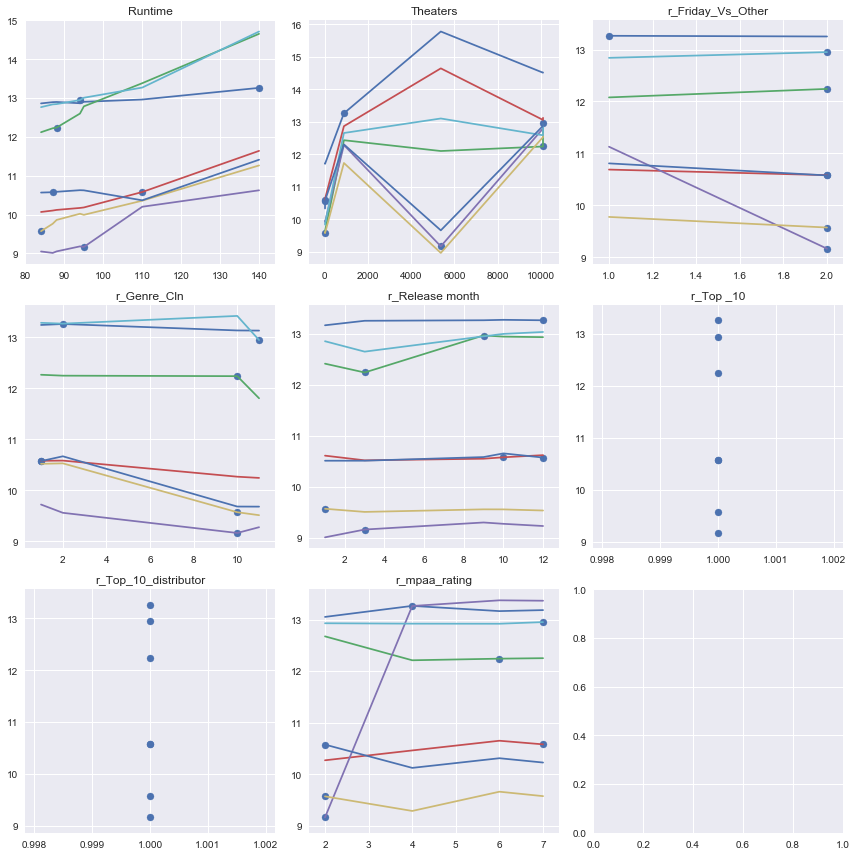

In [585]:
movie_test2 = X5_test.sample(500)
mtr2 = mli.ModelXRay(rfmodel4,movie_test[:7])
mliindices2 = mtr2.feature_dependence_plots(pts_selected=np.arange(7))
plt.savefig("rfmodel4_Insights.png", dpi= 300)



In [577]:
table = list(zip(X5_train.columns,rfmodel4.feature_importances_))

In [581]:
table

[('Runtime', 0.04848142413906268),
 ('Theaters', 0.63172833096674519),
 ('r_mpaa_rating', 0.14514383850265533),
 ('r_Genre_Cln', 0.027687213578924622),
 ('r_Release month', 0.014615857316925749),
 ('r_Friday_Vs_Other', 0.0058744522678850749),
 ('r_Top_10_distributor', 0.12635378347178064),
 ('r_Top _10', 0.00011509975602015091)]

In [584]:
plt.show()